# Project Introduction and Group Members

This is an academic project for the course Basics of Mobile Robotics taught at EPFL in winter 2021.
<br>
This project was done by:<br>
<br>Mariam Hassan
<br>Nay Abi Akl
<br>Alaa Abboud
<br>Luca Zunino
<br> <br> 
 

# Project Demo

Please check the videos below for a demonstration of multiple paths, different maps and different type of obstacles. In every tested situation, Thymio was able to follow the optimal path while avoiding the obstacles introduced and to reach its final goal destination.
<br>The first two demos show the optimal path plotted on a top view streaming of the map along with a video of Thymio following the path while avoiding local obstacles.
<br>The third demo shows another Thymio used as a dynamic obstacle representing a drunk car crossing the optimal path.
<br>The fourth demo shows that the camera was obstructed and Thymio was able to continue following its path.
<br>
1. https://youtu.be/Htc53pRaKMg
<br>
2. https://youtu.be/Bnllt1kFHOY
<br>
3. https://youtu.be/Du3KwuTA3x0
<br>
4. https://youtu.be/J9pF1u8dQ0c

# Installation of all necessary libraries <a class="anchor" id="Installationofallnecessarylibraries"></a>

pip uninstall opencv-python

In [ ]:
pip install opencv-contrib-python
pip install extremitypathfinder
pip install sympy

# Import all necessary libraries  <a class="anchor" id="Installationofallnecessarylibraries"></a>

In [1]:
import os
import cv2
import math
import time 
import sys
import glob
import timeit
import imutils
import numpy as np
import sympy as sym
from copy import deepcopy
from scipy.special import comb
import matplotlib.pyplot as plt
from imutils.video import VideoStream
from matplotlib.patches import Polygon
from extremitypathfinder import PolygonEnvironment
from extremitypathfinder.helper_classes import Vertex
from extremitypathfinder.plotting import PlottingEnvironment
from extremitypathfinder.helper_fcts import find_visible, find_within_range

# Environment <a class="anchor" id="ThymioCalibration"></a>

<div style="text-align: justify"> The map we considered during the testing phase and that we will use during the live demonstration represents some of the most iconic EPFL's buildings. In the left-hand-side image below, a satellite view of the EPFL campus is shown, on which we highlighted the buildings we used as static obstacles in our map. In the central image below, the map we use is shown. All the obstacles are 3-dimensional, not in scale, and are built using LEGO® bricks; they are represented using the same colour on the satellite image and the map. Note that, even if we imagined our static obstacles like buildings, and therefore not displaceable, the map is not hard-coded in any way: if we displace the buildings, we obtain a different map that can directly be used for tests.
From demo to demo, we are changing the start and/or the goal position of Thymio, that we imagined being a poor student that has to cross the whole campus in the most efficient way to be able to attend all lectures... it even has its CAMIPRO card (see right-hand-side image below)! Thymio has an ArUco marker to allow detecting it, and also the goal position is specified by an ArUco marker.</div>
    
<table><tr>
<td> <img src="images\EPFL_sat.png" alt="1" style="width: 500px"/> </td>
<td> <img src="images\2.png" alt="2" style="width: 500px"/> </td>
    <td> <img src="images\camipro.png" alt="3" style="width: 500px"/> </td>
</tr></table>

<br>
    
<div style="text-align: justify"> We then considered additional 3-dimensional obstacles that are added in different positions after the optimal path had been computed and Thymio had started moving: the purpose of these obstacles is to test local obstacle avoidance. We have tried using objects of different shapes and dimensions to test the robustness of our code, but during the live demonstration, we will mainly use two kinds of obstacles: </div>

* Another Thymio, static, that represents a student that is trying to reach the classroom in time for the lecture (left-hand-side image below);
* A yellow LEGO® building, static, that represents Chalet AGEP’ (right-hand-side image below). <br>

<div style="text-align: justify"> Note that, on the two images below, also the ArUco markers used to identify Thymio and the goal are displayed. </div>
    
<table><tr>
<td> <img src="images\IMG_3621.jpg" alt="1" style="width: 300px"/> </td>
<td> <img src="images\IMG_3622.jpg" alt="2" style="width: 300px"/> </td>
</tr></table>

# Thymio Calibration <a class="anchor" id="ThymioCalibration"></a>

<br>
<div style="text-align: justify">
No two motors rotate precisely the same: a given power level may result in different rotational speeds of the two motors. Therefore, calibration was needed to ensure that Thymio moves straight when instructed to do so. Thymio was calibrated according to the instructions found on the website: http://aseba.wikidot.com/en:thymiomotorcalibration . 
    
Before calibration, Thymio was not moving perfectly straight when instructed to do so; this behaviour can be seen in the leftmost picture below. After calibration, the movement improved a lot (see middle-right and rightmost pictures). <br>
The calibrated robot was the one used in all the trials and in the live demo. </div>   

<table><tr>
<td> <img src="images\before.jpg" alt="1" style="width: 250px"/> </td>
<td> <img src="images\during.png" alt="2" style="width: 250px"/> </td>
<td> <img src="images\after2.jpg" alt="4" style="width: 250px"/> </td>
<td> <img src="images\after.png" alt="3" style="width: 250px"/> </td>
</tr></table>


<div style="text-align: center"> Leftmost: before calibration. Middle-left: during calibration. Middle-right and rightmost: after calibration. </div>

# Orthogonal Projection Transformation

The camera plays a crucial role in this project. Not only is it used to take a picture of the map, which will then be processed to detect contours, vertices and visibility graphs, but it is the sensor upon which our Localization algorithm works.

To do the above, whatever frames provided by the camera and used for localization need to be parallel to the physical map we have, which is located on the ground. The concept is similar to one of the case studies discussed in class, whereby mounting a camera on top of the robot facing the ceiling would provide smoother and better localization as the ceiling is parallel to the 2D space the robot moves in.

Here, we wanted our camera output to be an image parallel to the 2D map the robot is navigating, such that we can have a linear mapping from the robot's location (in pixels) inside the camera's frame to its actual location (x,y) millimeters away from a certain reference frame (taken to be the starting position of the robot), in the physicaL map / 2D space.

Thus, the camera lens should be directed orthogonally towards the map, such that we get a pure top-view of the map. However, we lacked the necessary physical support to fix the camera in such a way and subsequently had to depend on our 'Frugal' creativity, using our software knowledge to compensate for the lack of physical resources.

The camera is fixed on a typical stand, with an oblique view of the map, as shown below:

 <img src = "images\1.png" width = 340 height = 280><br>
 
The four corners of the map are then detected manually using trackbars, with the pixel location of each corner extracted from the two intersecting trackbars.

The 4 corners of the map are then detected manually using trackbars, with the pixel location of each corner extracted from the 2 intersecting trackbars.

<table><tr>
<td> <img src="images\topleft.png" alt="1" style="width: 386px"/> </td>
<td> <img src="images\toplefttrackbar.png" alt="2" style="width: 300px"/> </td>
</tr></table>

The figures above showcase how we manually get the map's top left corner pixel location, through the intersection of two purple trackbar lines. The same approach is repeated to get all 4 corners. The code to do so is included in a separate notebook (Camera_Calibration_Process). Note that this is a camera calibration process done prior to videostreaming for the purpose of localization or taking images of the map.
 
Having the location of the four corners, we apply a sequence of perspective transformation and image warping to obtain the orthogonal to-view projection we need. The sequence is, in simple terms, a process of rotating, elongating, and scaling the input image. Through it, we transform the trapezoidal view of our map into a top-view one.

The sequence is applied using cv2.getPerspectiveTransform (which outputs the transformation matrix needed) and the cv2.warpPerspective function (which outputs the warped / transformed image) from the OpenCV library.

However, using these two functions by themselves gave us a transformed image that distorted the aspect ratio of our physical map. In other words, it changes the relative sizes and measurements of the map and the objects inside it. to showcase the seriousness of this side effect, we present the following transformation of an oblique view taken of an EPFL magazine hardcover and the corresponding top-view transformation. 

<table><tr>
<td> <img src="images\trapezoidal_original.png" alt="1" style="width: 386px"/> </td>
<td> <img src="images\Distorted.png" alt="2" style="width: 300px"/> </td>
</tr></table>

We thus had to complement the above sequence with additional lines of code such that the transformation not only outputs a top-view but also respects the aspect ratio of the physical map. Below is an image of the top-view transformation of the notebook after implementing our modifications.

<img src = "images\ar_perserved.png" width = 200 height = 320><br>

To do so, we wrote a function warp_ar_perserved(), whereby it utilizes the real-life size ratio (Width / Height) of a reference object in our camera frame, taken to be the ratio of our physical map borders (or of the notebook for the above showcase example). The ratio is used to dictate by how much the trapezoidal corners of our map in the oblique view should be rotated and scaled with respect to each other, preserving the aspect ratio in the process! It only took us an extra four lines of code to add this feature, and the results were satisfactory.

 <img src = "images\2.png" width = 340 height = 280><br>
 
Note that the new projected frame takes the map borders as its borders, removing unnecessary surrounding environment  (like the carpet shown) and isolating the map alone. 
 
Now that our camera gives a top view parallel to our map, Mapping from pixel location (inside the camera frame) to a real-life 2D pose of the robot becomes a linear process. The pixel location of the ro

In [2]:
def warp_ar_perserved(corner_points, image, ratio):
    ''' Compute the transformation matrix
    @ corner_points : 4 corner points selected from the image
    returns output : New warped image '''

    ''' Modified to preserve aspect ratio of the warped surface. The function is
    not used in below script but is kept here for reference. '''

    ''' the input parameter 'ratio' is the real life Width/Height ratio of the 
    cardboard '''

    # Create an array out of the 4 corner points
    pts1 = np.float32(corner_points)
    [tl,tr,br,bl] = pts1

    # Get the cardboard's pixel height and width in a manner that perserves 
    # aspect ratio
    cardH = math.sqrt(((br[0] - tr[0]) ** 2) + ((br[1] - tr[1]) ** 2))
    cardW = ratio * cardH;

    # fix the top left corner point of the Cardboard, and extract the new
    # corners using cardH and cardW
    pts2 = np.float32([[tl[0],tl[1]], [tl[0]+cardW, tl[1]], [tl[0]+cardW, tl[1]+cardH], [tl[0], tl[1]+cardH]])

    M = cv2.getPerspectiveTransform(pts1,pts2)
    
    # Add offset size (~padding) to the output's height and width
    # since the warped output is not a perfect rectangle (for display reasons)
    offsetSize = 500
    transformed = np.zeros((int(cardW + offsetSize), int(cardH + offsetSize)), dtype=np.uint8)
    warped_image = cv2.warpPerspective(image, M, transformed.shape) 
    
    return warped_image

# Initialization of parameters <a class="anchor" id="Initializationofparameters"></a>

<div style="text-align: justify"> The first variables in our code correspond to the actual size of our map in width and height specified as global variables. <br>
    
 After performing the warp perspective, we obtain a list of points and lengths representing the size of the image that will be obtained. These will also be initialized at the start of the code as global variables. <br>
    
Since we can extract distance information from the image in pixels, we will need to transform this distance into millimeters. This transformation is based on a simple calculation: we know that the real height and real width of the map in mm correspond to the warped height and warped width in pixels, we will use the ratio of the former (real) over the latter (warped) to convert any distance in pixel to mm, depending on whether the distance is in the 'x' or 'y' direction. Note that this is only viable because of the top view transformation explained previously. This conversion is used multiple times throughout the code, based on the variables defined below. A function will also be derived for this conversion in the code. </div>

In [3]:
# Real dimensions of the environment (white table sheet) in mm
real_width = 1310
real_height = 990
real_ratio = real_width/real_height

# Corner points of the trapezoidal map inputted to our top view perspective transformation function
# Top Left Point
tl = (100,116)
# Bottom Left Point
bl = (28,443)
# Top Right Point
tr = (535,123)
# Bottom Right Point
br = (621,443)

# Limits in height and width of the transformed environment 
# Height lower limit (top of image)
h1=122
# Height upper limit (bottom of image)
h2=441
# Width lower limit (left of image)
w1=108
# Width upper limit (right of image)
w2=530

# Warped dimensions of the image in pixels as difference of upper and lower limits
warped_width = w2-w1
warped_height = h2-h1

# Contours and Vertices

<div style="text-align: justify">In order to follow a path in our map, we need first to find the contours of all obstacles present and find the vertices of each contour to get the visibility graph later on. We decided to apply this process to a pre-saved image of the map containing the cardboard obstacles and not the 3D lego obstacles used subsequently because this makes the vertices detection through image processing more accurate. Note that the map is not hard coded, and the obstacle locations could be changed, but that would require taking another image and going through the process of detecting the contours again.

<br>
    
1. Finding contours and vertices:
    
    Based on the open-CV Python tutorials mentioned in the references section, a contour is a curve joining all the continuous points (along the boundary), having the same color or intensity. The function "cv2.findContours" could be used to find such contours with higher accuracy on binary images. Therefore, in our code, we first use a Guassian blur kernel to better deal with weak edges and smoothen the image. A canny edge detection is then done on the grayscale image of the map (to be compatible with the input image taken by cv2.findContours). The other two parameters expected by the function are the contour retrieval mode and the contour approximation method. The contour retrieval mode accounts for the hierarchy of contours found in the image and specifies which should be returned out of this hierarchy. The below image shows an example of nested contours. In our case, since we are interested in the outer edge of each contour which represents an obstacle (we do not care if the obstacle is empty from the inside or if it has more internal edges since the robot cannot access these anyway), we used the external retrieval mode where all child contours are left behind, and only the eldest in every contour is taken care of.
    
    <img src = "images\RetrievalContours.png" width = 300 height = 300><br>
    The second argument is the contour approximation method to specify what coordinates of the contour to store. As we can see in the image below, we could store the whole line or just store the two edges of each line. Since we are interested in vertices, we will only store the edges by using the cv2.CHAIN_APPROX_SIMPLE argument.
    <img src = "images\Approximation.jpg" width = 300 height = 300><br>
    
    We also use the built-in open-CV function "approxPolyDp" to get better precision and approximate polygonal contours' shape to the specified precision. It takes three arguments: the contour, epsilon which represents the maximum distance between the approximation and the original, and a boolean specifying if the contours are closed or not. In our case, epsilon is taken as a function of the arc length, and the contours are always considered as closed.<br>
    
    
2. Scaling contours function:
    
    When applying visibility graphs, the robot is taken as a point-like object; therefore, the contours found need to be scaled to account for the actual size of the robot. Ideally, the scaling is taken to be half the robot's size; in our case, 5.5cm is half of Thymio. However, to account for the lego obstacles, which are larger than the cardboard obstacles and give a slight margin of error, we decided to augment the obstacles by 2cm more, getting the final scale distance required to be 7.5cm = 75mm.
    
    In order to scale a contour, we make use of the "cv2.moments" function, which returns a dictionary of all moment values calculated. Based on these, we are able to obtain the centroid of each contour and subtract the coordinate of this center from the contour to translate it to the origin. Now, we can augment the contour by multiplying the coordinates by a scale factor. However, this scale factor is a percentage of the size of the contour and is not directly linked to the scaling distance we want. Therefore a more robust way is needed to augment.
    
    The method used focuses on two edges of the contour. Initially, the two edges are scaled up by 5%, and the distance between the original edge and the scaled edge is calculated. If the distance is sufficient (i.e. more than or equal to 75mm), the scaling factor is accepted and applied to all of the contour edges. If not, we loop again over the same process after increasing the scaling factor. Note that the calculation of distance between the two edges takes into account whether the edges are horizontal, vertical or at a certain slope. Also, note that the distance calculated between the edges corresponds to a distance in pixels, whereas the distance needed is specified in mm; therefore, a conversion from pixel to mm is needed to be able to compare the two distances. 
    
    Note that the optimal method to augment the obstacles is different from this one. In fact, the optimal method consists of approximating Thymio as a circle (in order to account for all possible orientations) and performing the Minkowski sum between each obstacle and Thymio to obtain an augmented shape. However, the augmented shape will not have vertices at this point; therefore, it should then be approximated with a polygon shape with edges and vertices. However, because of the computational complexity of such a method, we decided to stick to the more straightforward method that we derived, which in some cases (where the obstacle has a big difference in width and height, such as the elongated rectangles used in our map) does not account for Thymio in all directions. Therefore, in some situations and depending at what angle Thymio is heading towards the vertex, it might risk being too close to the obstacle, but this will be corrected using the local obstacle avoidance.
</div>

In [4]:
# A function to scale a contour 
# Argument: the contour to be scaled, the scaling distance required
# Output: the scaled contour 

def scale_contour(cnt, scale_dist):
    
    # Get the centroid of the contour
    M = cv2.moments(cnt)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    
    # Translate the contour to the origin by subtracting its center from every point
    cnt_norm = cnt - [cx, cy]

    # Work on one edge of the contour 
    x1 = cnt_norm[0][0][0]
    y1 = cnt_norm[0][0][1]
    x2 = cnt_norm[1][0][0]
    y2 = cnt_norm[1][0][1]
    
    # Start with a 5% scaling 
    i = 1.05
    
    # Flag indicating when the scaling factor is big enough
    correct_scale = False
    
    # Variable to hold the distance between the scaled and original edge 
    dist = 0
    
    # Loop until the scaling factor generates the minimum distance required
    while (not(correct_scale)):
        
        # Scale the 4 points of the 2 edges 
        x1_scaled = x1*i
        y1_scaled = y1*i
        x2_scaled = x2*i
        y2_scaled = y2*i
        
        # Get the distance between the scaled and original edge 
        # If the edge is horizontal, the distance is equal to the difference in 'y'
        # Convert from pixel to mm w.r.t. the ratio in height
        if y1 == y2:
            dist = abs(y2_scaled - y2)*real_height/warped_height
        
        # If the edge is vertical, the distance is equal to the difference in 'x'
        # Convert from pixel to mm w.r.t. the ratio in width
        elif x1 == x2:
            dist = abs(x2_scaled - x2)*real_width/warped_width
            
        # If the edge has a slope, find the equation of line of the original and scaled egde (y = mx + b)
        # and calculate perpendicular distance between the two
        else:
            # Find the slope of each edge
            m_original = (y2-y1)/(x2-x1)
            m_scaled = (y2_scaled - y1_scaled)/(x2_scaled-x1_scaled)
            
            # Find the intercept of each edge
            b_original = y1 - m_original*x1
            b_scaled = y1_scaled - m_original*x1_scaled
            
            # Find the perpendicular distance between the scaled and original edges 
            # Convert from pixel to mm w.r.t. the ratio in width to be more conservative 
            # because this is the maximum between height and width
            dist = (abs(b_scaled-b_original))/(math.sqrt((m_original*m_original) + 1))*real_width/warped_width
            
            
        # Check if the distance is equal or greater than the required scale and break if it is the case
        if (dist >= scale_dist):
            correct_scale = True
            break
        # If the required scaling distance is not yet reached, loop again while increasing the scaling factor i
        else:
            i = i+0.01

    # Do the required scaling with the scaling factor found 
    cnt_scaled = cnt_norm *i
    
    # Translate the contour back to the original place
    cnt_scaled = cnt_scaled + [cx, cy]
    cnt_scaled = cnt_scaled.astype(np.int32)

    return cnt_scaled



# A function to find vertices
# Argument: image to find vertices in
# Output: a list of lists containing the coordinates of vertices of each contour found in the image.

def find_vertices(image):
    
    #Load an image of the map
    fig = plt.figure(figsize=(16,9))
    ax1 = fig.add_subplot(221)
    ax1.title.set_text('Initial Image Of the Map')
    ax1.imshow(image)

    # Grayscale because cv2.findContours only takes grayscale images as input
    gray_img = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    
    # Use Gaussian Blur to filter out weak edges 
    blurred_img = cv2.GaussianBlur(gray_img, (5,5),0)
    
    # Start by finding edges using Canny Edge detection to reduce noise when applying find contours function
    edged_img = cv2.Canny(blurred_img, 10 , 90)
    ax2 = fig.add_subplot(222)
    ax2.title.set_text('Thresholded Image')
    ax2.imshow(edged_img)

    # Finding Contours 
    # Function takes 3 inputs: image, retrieval mode, approximation mode
    # Use external as retrieval mode to account only for the outer edges
    # Use simple approximation to get the vertices
    contours, hierarchy = cv2.findContours(edged_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # List to hold the vertices of augmented contours 
    verticesList = []

    # Loop over every contour in the list of contours found
    # Scale the contour
    # Extract the vertices of each augmented contour 
    # Append the vertices of each contour as a list of tuples
    
    for contour in contours:
        # The scaling distance is 75mm (Half of Thymio + Error margin)
        contour_augmented = scale_contour(contour, 75)
        
        # Approximate the vertices to the specified precision
        vertices = cv2.approxPolyDP(contour_augmented, 0.02*cv2.arcLength(contour,True), True)
        vertices = [tuple(vertices[i][0]) for i in range (len(vertices))]
        verticesList.append(vertices)
        print("Number of vertices of contour " +str(contours.index(contour)) + " is "  + str(len(vertices)))

        # Draw the vertices on the image for visualization
        for point in vertices:
            cv2.circle(image,(point[0],point[1]),5,(255,0,0),-1) 
    
    # Return the vertices in CCW to be compatible with the library used for the modified A* algorithm
    verticesList_cw = []
    h,w,c = image.shape
    for polygon in verticesList:
        vertices_cw = [polygon[-i-1] for i in range(len(polygon))]
        for i,vertex in enumerate(vertices_cw):
            vertex = list(vertex)
            vertex_translated = h - vertex[1]
            vertex[1] = vertex_translated
            vertex = tuple(vertex)
            vertices_cw[i] = vertex
            verticesList_cw.append(vertices_cw)

    # Draw the map with the augmented vertices 
    ax3 = fig.add_subplot(223)
    ax3.title.set_text('Augmented Obstacles')
    ax3.imshow(image)
    return verticesList_cw

As mentioned, the image of the map will be pre-saved (to avoid going through the whole warp perspective process during the presentation) and passed as an argument to the "find vertices" function, which will:
1. Find all contours in the image.
2. Augment the contours by half the size of Thymio (55cm) plus a margin of error (2cm) to account for the lego pieces added on the obstacles and not to let Thymio be precisely at the boundary of the obstacle.
3. Return a list of vertices for every augmented contour found in a CCW order to be compatible with the modified A* algorithm.

Note that some augmented vertices do not show on the image because they correspond to coordinates out of the image frame. These vertices will not be used anyway in finding the optimal path since they do not belong to the map anymore.

Number of vertices of contour 0 is 6
Number of vertices of contour 1 is 5
Number of vertices of contour 2 is 4
Number of vertices of contour 3 is 4


C:\Users\nayab\AppData\Local\Temp/ipykernel_9852/621037142.py:132: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  print("Number of vertices of contour " +str(contours.index(contour)) + " is "  + str(len(vertices)))


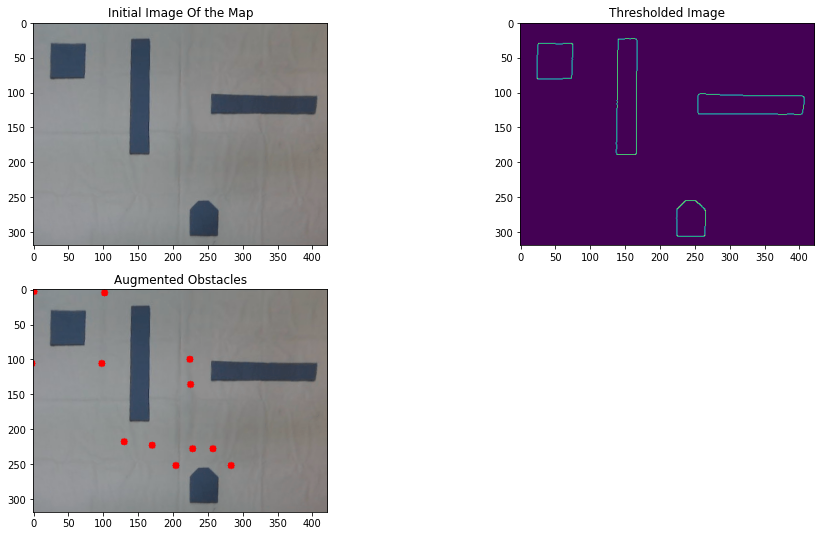

In [6]:
# Read the image of the map saved earlier on 
image_str = r"Map.png"
image = cv2.imread(image_str)
h,w, _ = image.shape

# Return the vertices list of each contour found
verticesList_cw = find_vertices(image)

# Aruco Markers to locate start and goal nodes

<div style="text-align: justify">Having the vertices of the obstacles is not enough since we also need the initial position of Thymio and the destination or goal position it needs to go to. We decided to use Aruco Markers to get the initial and goal positions. An ArUco marker is a "fiducial marker, binary square with black background and boundaries and a white generated pattern within it that uniquely identifies it." The black part makes it easier to detect it. <br>
 
   We did not write a code to generate the Aruco markers since an online tool is already available for this purpose. We used this tool (in the references) to generate two Aruco markers: the first for Thymio ("DICT_6X6_100") and the second for the goal ("DICT_7X7_100"). The size of the marker can also be chosen; we chose a size proportional to the size of our map and to the location of the camera w.r.t. to it.<br>

Based on the tutorial mentioned in the references list, the steps required to detect Aruco markers in openCV are shown in the figure below.<br>
    <img src = "images\detectAruco.png" width = 500 height = 500><br>
The image to load will be that of the map plus the Thymio with the Aruco on it and an Aruco on the desired goal node. The "cv2.aruco.Dictionary_get" function is used to grab the dictionary of ArUco markers we are using, after which we will define the Aruco detection parameters using the "cv2.aruco.DetectorParameters_create" function. The main function is the "cv2.aruco.detectMarkers" function which actually detects the Aruco and returns the corners (x, y coordinates of our detected ArUco markers) and the ids, which are the identifiers of the ArUco markers (i.e. the ID encoded in the marker itself).
Based on these values and by simple calculations, we can get the four corners of the marker, the center of the marker and its orientation. These values will be used to visualize Thymio and the goal on the image and will also be used to save our start coordinates and goal coordinates which will include (x, y, theta) coordinates. 
    <br>
    
   Note that for the 'y' coordinate, since the reference of the image is at the top left instead of the bottom left as our (x,y) axis, we translate the 'y' coordinates by subtracting it from the height of the image. Note also that since we are following a [-$ \pi $, $ \pi $] range for the angles, we use a function normalize_angle (found in Thymio Ground Localization Github) to normalize our angles and orientations to this range.
    <br>
    
   Note that in some calculations of angle differences, it was harder to calculate the difference and account for all possible quadrants and positive or negative values. Therefore, we preferred to switch back to degrees [0,360] to do our calculations and then switch back to the convention of angles used throughout the code. Therefore, we have a "denormalize" function for this purpose.

</div>

In [7]:
# Function to normalize an angle 
# Argument: angle to normalize
# Output: normalized angle

def normalize_angle(alpha):
    while alpha > math.pi:
        alpha -= 2. * math.pi
    while alpha < -math.pi:
        alpha += 2. * math.pi
    return alpha

# Function to unnormalize an angle 
# Argument: angle to denormalize
# Output: unnormalized angle

def denormalize(alpha):
    angle_deg = math.degrees(alpha)
    if (angle_deg > 0):
        return angle_deg
    else:
        return (angle_deg+360)

The initial position of Thymio is:
---------------------------------
x initial: 367
y initial: 290
Theta initial: -1.610775013918186

The goal position of Thymio is:
---------------------------------
x goal: 49
y goal: 191
Theta goal: 1.501939837493852


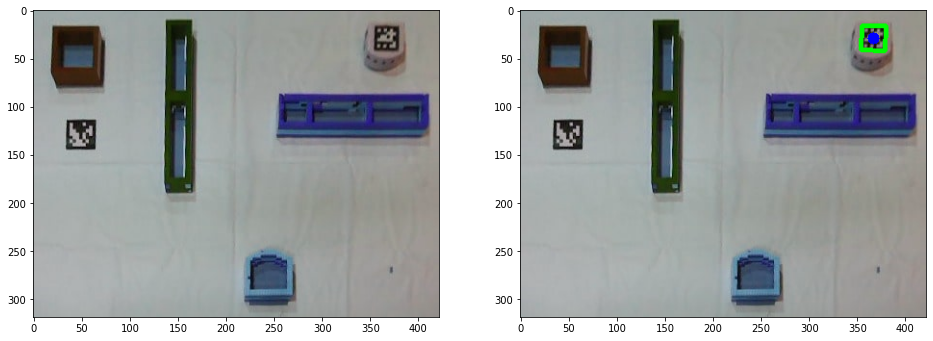

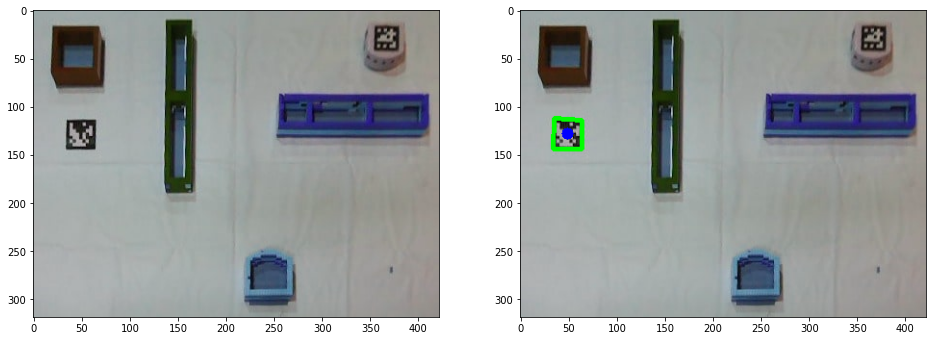

In [8]:
# Function to detect Aruco markers in an image
# Argument: image in which Aruco should be detected
# Output: (x,y,theta) coordinates of Aruco and height of image (for translation of the 'y' coordinate)

def detectArucoImage (str):
    # Define names of the ArUco tags used in the project
    ARUCO_DICT = {
    "DICT_6X6_50": cv2.aruco.DICT_6X6_50,
    "DICT_6X6_100": cv2.aruco.DICT_6X6_100,
    "DICT_6X6_250": cv2.aruco.DICT_6X6_250,
    "DICT_6X6_1000": cv2.aruco.DICT_6X6_1000,
    "DICT_7X7_50": cv2.aruco.DICT_7X7_50,
    "DICT_7X7_100": cv2.aruco.DICT_7X7_100,
    "DICT_7X7_250": cv2.aruco.DICT_7X7_250,
    "DICT_7X7_1000": cv2.aruco.DICT_7X7_1000,
    }

    #Load the image of the map with the start and goal Aruco
    image = cv2.imread(r"Start_Goal.jpeg")
    height, width, _ = image.shape

    plt.figure(figsize=(16,16))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    
    # verify that the supplied ArUCo tag exists and is supported by
    # OpenCV
    if ARUCO_DICT.get('DICT_6X6_1000', None) is None:
        print("[INFO] ArUCo tag of '{}' is not supported".format(
            'DICT_7X7_1000'))
        sys.exit(0)
        
    if ARUCO_DICT.get('DICT_7X7_1000', None) is None:
        print("[INFO] ArUCo tag of '{}' is not supported".format(
            'DICT_7X7_1000'))
        sys.exit(0)


    # load the ArUCo dictionary, grab the ArUCo parameters, and detect the markers 
    arucoDict = cv2.aruco.Dictionary_get(ARUCO_DICT[str])
    arucoParams = cv2.aruco.DetectorParameters_create()
    (corners, ids, rejected) = cv2.aruco.detectMarkers(image, arucoDict,parameters=arucoParams)

    # verify *at least* one ArUco marker was detected
    if len(corners) > 0:
        # Flatten the ArUco IDs list
        ids = ids.flatten()
        # loop over the detected ArUCo corners
        for (markerCorner, markerID) in zip(corners, ids):
            # extract the marker corners (which are always returned in
            # top-left, top-right, bottom-right, and bottom-left order)
            corners = markerCorner.reshape((4, 2))
            (topLeft, topRight, bottomRight, bottomLeft) = corners
            
            # convert each of the (x, y)-coordinate pairs to integers
            topRight = (int(topRight[0]), int(topRight[1]))
            bottomRight = (int(bottomRight[0]), int(bottomRight[1]))
            bottomLeft = (int(bottomLeft[0]), int(bottomLeft[1]))
            topLeft = (int(topLeft[0]), int(topLeft[1]))
            # Calculate theta in the range of [-pi,pi] following the positive axis and orientation convention
            theta = ((np.arctan2((topRight[1]-topLeft[1]),(topRight[0]-topLeft[0])))-((math.pi)/2))*-1


            # Draw the bounding box of the ArUCo detection
            cv2.line(image, topLeft, topRight, (0, 255, 0), 4)
            cv2.line(image, topRight, bottomRight, (0, 255, 0), 4)
            cv2.line(image, bottomRight, bottomLeft, (0, 255, 0), 4)
            cv2.line(image, bottomLeft, topLeft, (0, 255, 0), 4)
            
            # compute and draw the center (x, y)-coordinates of the ArUco
            # marker
            cX = int((topLeft[0] + bottomRight[0]) / 2.0)
            cY = int((topLeft[1] + bottomRight[1]) / 2.0)
            cv2.circle(image, (cX, cY), 6, (0, 0, 255), -1)

    plt.subplot(1, 2, 2)
    plt.imshow(image)
    
    return cX,cY,theta, height

start_coord_X, start_coords_Y, start_Orientation, height_start = detectArucoImage('DICT_6X6_1000')

# Translate the 'y' coordinate to match the x,y axis
start_coords_Y = height_start - start_coords_Y

# Normalize the angle representing the orientation
start_Orientation = start_Orientation % (2*math.pi)
start_Orientation = normalize_angle(start_Orientation)
start_coordinates = (start_coord_X, start_coords_Y)

print("The initial position of Thymio is:")
print("---------------------------------")
print("x initial: " + str(start_coord_X))
print("y initial: " + str(start_coords_Y))
print("Theta initial: " + str (start_Orientation))
print()

goal_coord_X, goal_coord_Y, goal_Orientation, height_goal = detectArucoImage('DICT_7X7_1000')

# Translate the 'y' coordinate to match the x,y axis
goal_coord_Y = height_goal - goal_coord_Y

# Normalize the angle representing the orientation
goal_Orientation = goal_Orientation % (2*math.pi)
goal_Orientation = normalize_angle(goal_Orientation)
goal_coordinates = (goal_coord_X, goal_coord_Y)

print("The goal position of Thymio is:")
print("---------------------------------")
print("x goal: " + str(goal_coord_X))
print("y goal: " +str(goal_coord_Y))
print("Theta goal: " + str (goal_Orientation))

# Global Navigation using Visibility Graphs

To find the optimal path, we relied on the theory of Visibility Graphs, complemented by an optimized A* algorithm. The code we used was adapted from the 'ExtremityPathFinder' Github repository. However, the two approaches differ from the ordinary/typical implementation of the algorithms by utilizing two fundamental principles explained later on in this section.

We used several helper functions and classes from the said repository, with some being modified to fit the output format we needed so that it was compatible with the rest of the modules and subsystems used during the integration process.

The below cell contains the different plotting functions we used from the repository to demonstrate the internal process/sequence of steps we must go through to reach a final optimized path. We will not delve much into the plotting functions as they are void of theory, utilizing generic pythonic plotting approaches.

In [9]:
# Some settings used for plotting 
POLYGON_SETTINGS = {
    "edgecolor": "black",
    "fill": False,
    "linewidth": 1.0,
}

# Helper functions used for plotting
def draw_graph(map, graph, start_node, goal_node):
    fig, ax = plt.subplots()

    all_nodes = graph.get_all_nodes()
    mark_points(all_nodes, c="black", s=30)

    for n in all_nodes:
        x, y = n.coordinates
        neighbours = graph.get_neighbours_of(n)
        for n2 in neighbours:
            x2, y2 = n2.coordinates
            dx, dy = x2 - x, y2 - y
            if (x,y) != start_node and (x2,y2) != goal_node:
                plt.arrow(
                    x,
                    y,
                    dx,
                    dy,
                    head_width=0.15,
                    head_length=0.5,
                    head_starts_at_zero=False,
                    shape="full",
                    length_includes_head=True
                )
                
            if (x,y) == start_node:   
                plt.arrow(
                    x,
                    y,
                    dx,
                    dy,
                    head_width=0.15,
                    head_length=0.5,
                    head_starts_at_zero=False,
                    shape="full",
                    length_includes_head=True,
                    color='green'
                )
            
            if (x2,y2) == goal_node:  
                plt.arrow(
                    x,
                    y,
                    dx,
                    dy,
                    head_width=0.15,
                    head_length=0.5,
                    head_starts_at_zero=False,
                    shape="full",
                    length_includes_head=True,
                    color='red'
                )
            

    set_limits(map, ax)
    plt.show()
        
def mark_points(vertex_iter, **kwargs):
    try:
        coordinates = [v.coordinates.tolist() for v in vertex_iter]
    except AttributeError:
        coordinates = list(vertex_iter)
    coords_zipped = list(zip(*coordinates))
    if coords_zipped:  # there might be no vertices at all
        plt.scatter(*coords_zipped, **kwargs)
        
def set_limits(map, ax):
    ax.set_xlim(
        (
            min(map.boundary_polygon.coordinates[:, 0]) - 1,
            max(map.boundary_polygon.coordinates[:, 0]) + 1,
        )
    )
    ax.set_ylim(
        (
            min(map.boundary_polygon.coordinates[:, 1]) - 1,
            max(map.boundary_polygon.coordinates[:, 1]) + 1,
        )
    )

def draw_path(vertex_path):
# start, path and goal in green
    if vertex_path:
        mark_points(vertex_path, c="g", alpha=0.9, s=50)
        mark_points([vertex_path[0], vertex_path[-1]], c="g", s=100)
        v1 = vertex_path[0]
        for v2 in vertex_path[1:]:
            draw_edge(v1, v2, c="g", alpha=1.0)
            v1 = v2
            
def draw_boundaries(map, ax):
    # TODO outside light grey
    # TODO fill holes light grey
    draw_polygon(ax, map.boundary_polygon.coordinates)
    for h in map.holes:
        draw_polygon(ax, h.coordinates, facecolor="grey", fill=True)

    mark_points(map.all_vertices, c="black", s=15)
    mark_points(map.all_extremities, c="red", s=50)
    
def draw_polygon(ax, coords, **kwargs):
    kwargs.update(POLYGON_SETTINGS)
    polygon = Polygon(coords, **kwargs)
    ax.add_patch(polygon)

def draw_internal_graph(map, ax):
    for start, all_goals in map.graph.get_neighbours():
        for goal in all_goals:
            draw_edge(start, goal, c="red", alpha=0.2, linewidth=2)


def draw_prepared_path(map,vertex_path):
    fig, ax = plt.subplots()
    draw_boundaries(map, ax)
    draw_path(vertex_path)
    set_limits(map, ax)
    
def draw_edge(v1, v2, c, alpha, **kwargs):
    if type(v1) == tuple:
        x1, y1 = v1
        x2, y2 = v2
    else:
        x1, y1 = v1.coordinates
        x2, y2 = v2.coordinates
    plt.plot([x1, x2], [y1, y2], color=c, alpha=alpha, **kwargs)


Independently of any query start and goal points, the optimized visibility graph is being computed for the static environment once. The optimization is based on principles discussed in a couple of cells below.

In [10]:
rootdir = 'env'
image = cv2.imread(r"Map.png")
h,w,c = image.shape
boundary_coordinates = [(0,0), (w,0), (w,h), (0,h)]
environment = PlottingEnvironment(plotting_dir=rootdir)
environment.store(boundary_coordinates, verticesList_cw, validate=True)
environment.prepare()

graph = environment.graph
neighbours = graph.get_neighbours()

possible_edges = []

# from draw_internal_graph fct of plotting
for start, all_goals in neighbours:
        for goal in all_goals:
            # get_distance fct from helper classes
            # distances.append(graph.get_distance(start,goal))
            possible_edges.append((start,goal))

<div style="text-align: justify">
The following bridges between the visibility graph obtained earlier and the optimal path to be obtained, through an A* algorithm modified to decrease the exhaustiveness of search and eliminate definitively sub-optimal paths prior to the search process!

As mentioned above, this optimization of the visibility graph approach depends on two principles.

The first principle helps reduce the visibility graph (nodes and edges) without the loss of guaranteed optimality of the algorithm:

Starting from any point 'p' lying "in front of" an extremity / vertgex 'e', such that both adjacent edges (sides of the polygon stemming from 'e') are visible, one will never visit 'e', because everything is reachable on a shorter path without the need to visit 'e' (except when 'e' is the goal node) :

<table><tr>
<td> <img src="images\principle1_1.jpeg" alt="1" style="width: 500px"/> </td>
<td> <img src="images\principle2_1.jpeg" alt="2" style="width: 500px"/> </td>
</tr></table>

From the figure, it is evident that path (1), which does not pass through 'e', is shorter than path (3), which does, and that path (2) is shorter than path (4). Note that this is only applicable in cases where the adjacent edges of extremity 'e' (drawn in green) are visible to the node we are currently sitting at.

Hence, when coming from 'p', everything else than 'e' itself can be reached faster without visiting 'e'. Therefore, 'p' and 'e' do not have to be connected in the graph. When applied to all the possible nodes/extremities in a given map, this basic principle allows us to reduce our visibility graph's size and time complexity without any loss of optimality.

The second principle:

It is always shortest to directly reach a node instead of visiting other nodes first in the process of getting to the directly reachable node:

<table><tr>
<td> <img src="images\principle1_2.jpeg" alt="1" style="width: 500px"/> </td>
<td> <img src="images\principle2_2.jpeg" alt="2" style="width: 500px"/> </td>
</tr></table>

We can see that path (1) is shorter than paths (2) and (3). Thus, there can be no other shorter path to it when the goal is directly reachable.

Modified A* Algorithm:

The modification to the A* algorithm utilizes the principles mentioned above. Three cases can be derived to make the A* search less exhaustive and improve efficiency:

1) when the goal is directly reachable, there can be no other shorter path to it. Terminate.

2) there is no need to revisit nodes (path only gets longer)

3) not all neighbours of the current node have to be checked like in vanilla A* before continuing
        to the next node  </div> 

In [11]:
def find_optimal_path(start_coordinates, goal_coordinates):
    start_vertex = Vertex(start_coordinates)
    goal_vertex = Vertex(goal_coordinates)

    environment.translate(goal_vertex)
    start_vertex.mark_outdated()

    candidates = set(
                filter(
                    lambda n: n.get_angle_representation() is not None,
                    graph.get_all_nodes(),
                )
            )

    candidates.add(start_vertex)

    visibles_n_distances_goal = find_visible(
                candidates, edges_to_check=set(environment.all_edges))

    if len(visibles_n_distances_goal) == 0:
        # The goal node does not have any neighbours. Hence there is not possible path to the goal.
        print(" Not possible to reach goal")

    # create temporary graph TODO make more performant, avoid real copy
    # DirectedHeuristicGraph implements __deepcopy__() to not change the original precomputed self.graph
    # but to still not create real copies of vertex instances!
    environment.temp_graph = deepcopy(environment.graph)

    # IMPORTANT geometrical property of this problem: it is always shortest to directly reach a node
    #   instead of visiting other nodes first (there is never an advantage through reduced edge weight)
    # -> when goal is directly reachable, there can be no other shorter path to it. Terminate

    for v, d in visibles_n_distances_goal:
        if v == start_vertex:
            return ([start_coordinates, goal_coordinates], d, [start_vertex, goal_vertex])
            # add unidirectional edges to the temporary graph
            # add edges in the direction: extremity (v) -> goal
            # environment.temp_graph.add_directed_edge(v, goal_vertex, d)
        # add unidirectional edges to the temporary graph
        # add edges in the direction: extremity (v) -> goal
        environment.temp_graph.add_directed_edge(v, goal_vertex, d)
        #possible_edges.append((v,d))
        possible_edges.append((v,goal_vertex))

    environment.translate(start_vertex) 
    # do before checking angle representations!
    # the visibility of only the graphs nodes have to be checked
    # the goal node does not have to be considered, because of the earlier check
    candidates = set(
                filter(
                    lambda n: n.get_angle_representation() is not None,
                    environment.graph.get_all_nodes(),
                )
            )

    visibles_n_distances_start = find_visible(
                candidates, edges_to_check=set(environment.all_edges)
            )

    if len(visibles_n_distances_start) == 0:
        # The start node does not have any neighbours. Hence there is not possible path to the goal.
        return("No possible path",0,0)

    # add edges in the direction: start -> extremity
    for v, d in visibles_n_distances_start:
        environment.temp_graph.add_directed_edge(start_vertex, v, d)
        possible_edges.append((start_vertex,v))

    # for every extremity that is visible from either goal or start
    # NOTE: edges are undirected! self.temp_graph.get_neighbours_of(start_vertex) == set()
    # neighbours_start = self.temp_graph.get_neighbours_of(start_vertex)
    neighbours_start = {n for n, d in visibles_n_distances_start}
    # the goal vertex might be marked visible, it is not an extremity -> skip
    neighbours_start.discard(goal_vertex)
    neighbours_goal = environment.temp_graph.get_neighbours_of(goal_vertex)
    for vertex in neighbours_start | neighbours_goal:
        # assert type(vertex) == PolygonVertex and vertex.is_extremity
        # check only if point is visible
        temp_candidates = set()
        if vertex in neighbours_start:
            temp_candidates.add(start_vertex)

        if vertex in neighbours_goal:
            temp_candidates.add(goal_vertex)

        if len(temp_candidates) > 0:
            environment.translate(new_origin=vertex)
            # IMPORTANT: manually translate the goal and start vertices
            start_vertex.mark_outdated()
            goal_vertex.mark_outdated()

            n1, n2 = vertex.get_neighbours()
            repr1 = (n1.get_angle_representation() + 2.0) % 4.0  # rotated 180 deg
            repr2 = (n2.get_angle_representation() + 2.0) % 4.0
            repr_diff = abs(repr1 - repr2)

            # IMPORTANT: special case:
            # here the nodes must stay connected if they have the same angle representation!
            lie_in_front = find_within_range(
                repr1,
                repr2,
                repr_diff,
                temp_candidates,
                angle_range_less_180=True,
                equal_repr_allowed=False,
            )
            environment.temp_graph.remove_multiple_undirected_edges(vertex, lie_in_front)

    # NOTE: exploiting property 2 from [1] here would be more expensive than beneficial
    vertex_path, distance = environment.temp_graph.modified_a_star(start_vertex, goal_vertex)
    
    return(vertex_path)

<div style="text-align: justify">As we saw in the "find_optimal_path" function, we need to pass two arguments. The first is the start position, and the second is the goal position. Both were obtained with the Aruco marker detection and saved in the "start_coordinates" and "goal_coordinates" variables. Here, we pass these two variables to the function, which return the optimal path as a list of tuples, each representing a node in the optimal path. <br>Note that the node coordinates are still in pixel format here.</div>

In [12]:
#optimal_path, total_distance, vertex_path = find_optimal_path(start_coordinates, goal_coordinates)
vertex_path = find_optimal_path(start_coordinates, goal_coordinates)
print("The optimal path corresponds to the following sequence of nodes: ")
print("----------------------------------------------------------------")
print(vertex_path)

The optimal path corresponds to the following sequence of nodes: 
----------------------------------------------------------------
[(367, 290), (224, 219), (170, 96), (130, 101), (49, 191)]


<div style="text-align: justify"> Here, we make use of two helper functions to visualize what the algorithm computed. The first graph shows the start node and the vertices visible to it in green, and the goal node and the edges visible to it in red. <br> Note that edges connecting vertices of the obstacles are also added (which explains the slightly strange graph, but if you follow the edges, all of them are correct and actually found in the map).<br>

The second graph shows what is the optimal path that was found by the algorithm, going from the start node to the end node while passing by a series of vertices.<br> Note that the obstacles are shown as augmented in this graph and not as the initial obstacles.</div>

Graph showing start and goal nodes with optimal visible edges: 


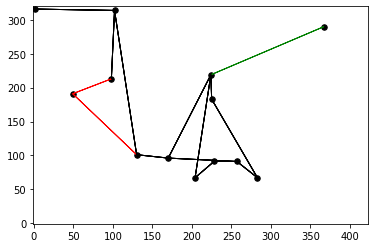

Graph showing the optimal path from start to goal with visited edges: 


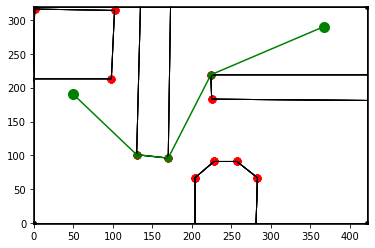

In [13]:
print("Graph showing start and goal nodes with optimal visible edges: ")
draw_graph(environment, environment.temp_graph, start_coordinates, goal_coordinates)
print("Graph showing the optimal path from start to goal with visited edges: ")
draw_prepared_path(environment,vertex_path)

# Discretization of the optimal path

## The reason behing smoothing and discretizing the path

<div style="text-align: justify">Initially, we thought we should apply the optimal path consisting of a set of nodes directly in the path following the algorithm. However, after going through the literature, we found that it is a better practice to smooth the path obtained beforehand. <br>

Path smoothing techniques are popular in path following robotics applications. In fact, in many situations, the environment is considered as discrete and problems are solved by finding the shortest path going through a set of nodes up until the terminal node. However, this method does not consider actual limitations in the robot's movements; it generates purely straight lines with possibly sharp and angular turns. These are not optimal for robot motion since we know that the motion is less accurate in turns, and the robot would have to slow down in order not to overshoot while going through the sharp turns. On the contrary, smoother trajectories would reduce the effect of sharp turns, but the smoothing should be done while taking into consideration the static obstacles since sharp turns can be found at the edges of these obstacles and smoothing the curve too much could risk getting the robot too close to the obstacle boundary.<br>

Many techniques exist for smoothing trajectories: Dubins curve, Bezier curve, splines, nurbs, clothoids, etc. Many of these techniques depend on the number of points given in the initial path. If we have a small number of points that are distant, smoothing the curve could result in deviating a lot from the straight lines found by the shortest path algorithm and risk changing the path very much, which is not desired because it would negate the effort done to find the shortest path. The solution that we decided to implement to avoid this problem is to discretize the optimal path, i.e. add more points along the straight lines found between one node and the other. Smoothing applied on the increased number of nodes results in a smoother path that is closer to the optimal path and reduces the risk of large deviations, which is our desired output.
    
   Another main reason that led us to choose to discretize the path is to improve the performance of the controller in path following. In fact, the nodes found in the optimal path are quite sparse and distant from each other with respect to the total distance to be covered. Since the controller is responsible for making the robot follow the path and correcting its position at the different nodes, this means that the robot has to cover a somewhat significant distance between one node and the next before correcting or adjusting to the path. By actual trial and observation with Thymio, we saw that this leads to some divergence from the optimal path. In fact, the controller is given the set of nodes, it takes the first node as starting node and the next one as a goal node and creates its own path (spline or curved) between the two points and this path created by the controller is not bounded by any intermediate trajectory between these two nodes. Therefore, if the distance between the nodes is large, this path chosen by the controller could deviate significantly from the straight-line path initially found by the shortest path algorithm.
    
   Thus, having more nodes on the path would help Thymio better follow the shortest path based on the controller and to correct its position and orientation accordingly. Based on the discretization technique chosen and how its parameters are set, one could choose to have a smoothed path with more nodes (the number depends on the parameters), and this was taken into consideration while choosing the discretization parameters (mainly the distance between nodes) and the smoothing technique and applying it to our project.<br>

Note that if the number of nodes on the path is too large, making the nodes too close to each other, the controller will try to correct the position and the orientation of Thymio too much in a small distance which will lead to a very "zig zaggy" motion of Thymio (also observed by trial). Therefore, there is a tradeoff between discretizing the path and the number of nodes obtained in order to get the best motion for Thymio possible.<br><div/>

## Discretization of the path

To discretize the optimal path, we need to discretize the straight line connecting every two consecutive nodes. This is divided into three functions that are based on simple geometry, and that follow a certain hierarchy.
1. The first function, "getLineParameters", returns the straight line connecting two points by finding the equation of this line. Since this function will be given nodes of the optimal path, it means that the lines found will match the straight lines of the optimal path that we want to discretize.
<br>

2. The second function, "discretizeLine", divides the straight line connecting two points into a set of points. It is given the two points of the line as input, and it calls the first function "getLineParameters" to obtain the line connecting the two points. Having this line, the function divides it into a set of points spaced by a distance 'h' in pixels. This is done by solving two symbolic equations. Note that the "sym.solve" function takes as a first input an equation(s) (equalled to 0) and as a second input the point to solve for. In our case, we pass it two equations to be solved for the same new point to be added on the line.
<br>
The first equation represents the difference between "h" (the distance required between the discretized points) and the distance from the new point to the start point of the line. By setting this equation to zero, we ensure that the distance between the new point and the start point is equal to "h". To account for subsequent points, "h" is multiplied by an index "i", representing the index of the point to be added. For example, the second point to be added should be "2*h", distant from the start point of the line.
<br>
<br>
The second equation is the equation of the line being considered w.r.t. the new point. By setting this equation to zero, we ensure that the new point being found actually lies on the straight line that we are discretizing.
<br>
<br>
The second function also considers the direction of the edge being considered to add the coordinates of the new points being found correctly.

The below figure is a visual representation of the method explained.
<img src = "images\Discretization.jpeg" width = 500 height = 500><br>


3. The third function "discretizeLines", is used because the optimal path is made of a set of nodes, each two joined by a straight line. In order to discretize the whole path, we need to discretize the individual lines connecting every two consecutive nodes. Therefore, this function is used to loop over all of the nodes of the optimal path, taking every two consecutive nodes at a time, passing them to the "discretizeLine" function and storing the discretized points obtained until all of the optimal path is discretized.

In [14]:
# Function to find the line connecting two points 
# Input: two points 
# Output: straight line joining the two points

def getLineParameters(pt1, pt2):
    # Given two points in list format [x,y], computes the parameters a and b of the line joining them y=ax+b
    a = (pt2[1] - pt1[1])/(pt2[0]-pt1[0])
    b = pt2[1] - a*pt2[0]
    return a,b


# Function to discretize a line joining two points
# Input: Two points pt1, pt2 joining the line to be discretized
# Output: A set of points spaced by a pixel value of 'h; along the straight line joining pt1 and pt2

def discretizeLine(pt1,pt2,h):

    # Append the first node to the line
    line = [[pt1[0], pt1[1]]]
    
    # Get the parameters of the equation of the line connecting the two points
    [a,b] = getLineParameters(pt1, pt2)
    
    # Get the distance of the line to be covered while discretizing
    temp1 = math.sqrt((pt2[0]-pt1[0])**2+(pt2[1]-pt1[1])**2)
    index = 1
    
    #Calculate the step in the x direction for the line
    while temp1>h:
        x_new, y_new = sym.symbols('x_new, y_new') 
        
        # First equation to account for the distance
        eq1 = sym.Eq((index*h)-sym.sqrt((x_new-pt1[0])**2+(y_new-pt1[1])**2))
        
        # Second equation to set the new point on the line 
        eq2 = sym.Eq(a*x_new+b,y_new)
        
        # Solve the equation for the required new point
        result = sym.solve([eq1,eq2],(x_new,y_new))
        
        # Take care of the direction of the edge when adding the new point
        if pt2[0]>pt1[0]:
            line.append([result[1][0], result[1][1]])
        else:
            line.append([result[0][0], result[0][1]])
            
        # Keep looping until you cover the whole distance of the line joining the two points 
        temp1 = temp1 - h
        index = index + 1 

    return line



# A function to loop over all sections of the optimal path and discretize them
# Input: A set of points corresponding to the path we wish to optimize, a step size in pixels h 
# Output: A set of points corresponding to the disretization of the input path

def discretizeLines(path, h):
    # Variable to hold the new discretized line
    new_path = []
    
    # Loop to obtain lines connecting two consecutive nodes on the path
    for i in range(len(path)-1):
        line = discretizeLine(path[i].coordinates[0:2],path[i+1].coordinates[0:2],h)
        new_path = new_path + line

    # Append the goal node to the line after discretizing it
    new_path.append([path[-1].coordinates[0],path[-1].coordinates[1]])
    
    return new_path


## Smoothing through Bezier curve  

<div style="text-align: justify">
    Out of the possible techniques to smooth a path, we decided to use Bezier curves. In fact, this technique has a low computational cost, the curve generated can have specific characteristics based on the control points given and multiple Bezier curves can be connected together to get a complete path which is ideal in our case.<br>
    
   The mathematical basis of this technique, based on "TowardsDataScience" tutorial mentioned in the references list, is the following. <br>Given n+1 points $ (P_0, ..., P_n) $ called the "control points", the Bezier curve defined by these points is:
    <img src = "images\Bezier 1.png" width = 400 height = 300><br>
    
   with B(t) being the Bernstein polynomial:
    <img src = "images\Bezier 2.png" width = 400 height = 500><br>
    
   Therefore, two functions are used to find the Bezier curve and smooth the path. The first is a function that returns the Berstein polynomial "bernstein_poly" and the second to return the bezier curve using the Berstein polynomial found "bezier_curve". Both functions implement the equations found in the images above with some consideration for the format in which the points are returned to be compatible with the rest of the functions used in the code. The set of points found by discretizing the path is passed as control points to the Bezier curve function by setting the number of time steps to the number of discretized points.
    
</div>

In [15]:
#Berstein Polynomial
def bernstein_poly(i, n, t):
    # The Bernstein polynomial of n, i as a function of t
    return comb(n, i) * ( t**(n-i) ) * (1 - t)**i

#Bezier Curve
def bezier_curve(points, nTimes):
    # Given a set of control points, return the bezier curve defined by them.
    # Points should be a list of lists, or list of tuples
    # nTimes is the number of time steps

    nPoints = len(points)
    xPoints = np.array([p[0] for p in points])
    yPoints = np.array([p[1] for p in points])

    t = np.linspace(0.0, 1.0, nTimes)

    polynomial_array = np.array([bernstein_poly(i, nPoints-1, t) for i in range(0, nPoints)])

    xvals = np.dot(xPoints, polynomial_array)
    yvals = np.dot(yPoints, polynomial_array)

    return xvals, yvals

Based on the logic explained above, the following cell executes the two steps that need to be done:
1. Discretize the optimal path. Here, the distance in pixels between the discretized points needs to be specified. As mentioned previously, this distance should not be too small for the motion to be smooth and not too large in order not to deviate from the optimal path. This distance also plays a role in the obstacle avoidance algorithm; however, the explanation for this is left for the section on obstacle avoidance. Therefore, the choice of 'h' takes into account all the aspects mentioned above.
<br>

2. Smooth the discretized path obtained using the Bezier curve technique.
<br>

3. Add the orientation needed for Thymio at every node in the smoothed discretized path as being the angle of the line connecting two consecutive nodes.

In [16]:
# Distance in pixels between discretized points
h_for_discretization = 40

# Discretize the optimal path
discrete_path = discretizeLines(vertex_path, h_for_discretization)

# Smooth the path using Bezier curve 
params=len(discrete_path)
xvals, yvals = bezier_curve(discrete_path, nTimes=params)
xvals = np.flip(xvals)
yvals = np.flip(yvals)

# Add the orientation needed at every node
discretized_path = []
for i in range(params-1):
    theta = math.atan2((yvals[i+1]-yvals[i]),(xvals[i+1]-xvals[i]))
    discretized_path.append((xvals[i], yvals[i],theta))
    
# Append goal node twice, needed for looping in the main function without going over index range
discretized_path.append((goal_coordinates[0],goal_coordinates[1], goal_Orientation))
discretized_path.append((goal_coordinates[0],goal_coordinates[1], goal_Orientation))

C:\Users\nayab\AppData\Local\Programs\Python\Python39\lib\site-packages\sympy\core\relational.py:495: SymPyDeprecationWarning: 

Eq(expr) with rhs default to 0 has been deprecated since SymPy 1.5.
Use Eq(expr, 0) instead. See
https://github.com/sympy/sympy/issues/16587 for more info.

  SymPyDeprecationWarning(


The points of the discretized path correspond to pixel locations on the image. However, we would like to give to the controller points corresponding to the actual environment in mm. Therefore, the start point (corresponding to Thymio at its initial position captured by the Aruco marker) is set as the reference point in both the pixel and mm representation. The position of all other points is taken with respect to this reference point; the new coordinates are obtained as follows: 
1. Calculate the distance to this reference point in pixels in both x and y directions $ ( x - x_0, y - y_0)$

2. Multiply by a ratio to convert into mm, the ratio being the real size of the environment over the warped size. In the 'x' direction, this corresponds to (real_width/warped_width). In the 'y' direction, this corresponds to (real_height/warped_height).

3. Add the coordinate of the initial point since it is taken as reference (i.e. $ x_0 $, $ y_0 $)

The final equation is of the following form: $ (x - x_0) * ratio + x_0 $

In [17]:
discretized_path_mm = []
initial_pose = discretized_path[0]
discretized_path_mm.append((initial_pose[0]*1000,initial_pose[1]*1000,initial_pose[2]))

for i in range(1,len(discretized_path)):
    new_x = ((discretized_path[i][0] - initial_pose[0])*real_width/warped_width) + initial_pose[0]*1000
    new_y = ((discretized_path[i][1] - initial_pose[1])*real_height/warped_height) + initial_pose[1]*1000
    discretized_path_mm.append((new_x,new_y,discretized_path[i][2]))

print("Points of the discretized path in mm")
print("-------------------------------------")
print(discretized_path_mm)
    

Points of the discretized path in mm
-------------------------------------
[(367000.000000000, 290000.000000000, -2.6791967642187746), (366888.945345840, 289944.660896532, -2.6501039443776135), (366780.749161376, 289886.758516850, -2.553522927028053), (366681.667929383, 289820.712145068, -2.4056403904983363), (366596.473441832, 289743.572288982, -2.2710373215831257), (366525.338348653, 289659.181245925, -2.210032597734342), (366464.542208449, 289577.416892482, -2.263757770764819), (366408.857802377, 289510.371323843, -2.4880062878113147), (366353.807473691, 289468.220539065, -2.943656090226182), (366296.716766203, 289456.773286385, 2.8180410996171203), (366236.276164525, 289477.035839667, 2.4985029222470083), (366171.769584864, 289525.361599834, 2.3591110248701264), (366104.555804039, 289592.166867457, 2.3128867818337895), (366043.559931497, 289658.671184172, 2.3040901880831486), (366012.843601896, 289692.758620690, 1.501939837493852), (366012.843601896, 289692.758620690, 1.50193983749

We can see from the points above that each point has 3 coordinates: x, y, and theta which represents the optimal orientation of the robot at this point. x,y coordinates are w.r.t. the first position of Thymio, the orientation is w.r.t. the positive x-axis and positive for CCW. The discretized path is visualized in the graph below.

Graph showing the nodes of the optimal path after discretizing and smoothing it:
--------------------------------------------------------------------------------


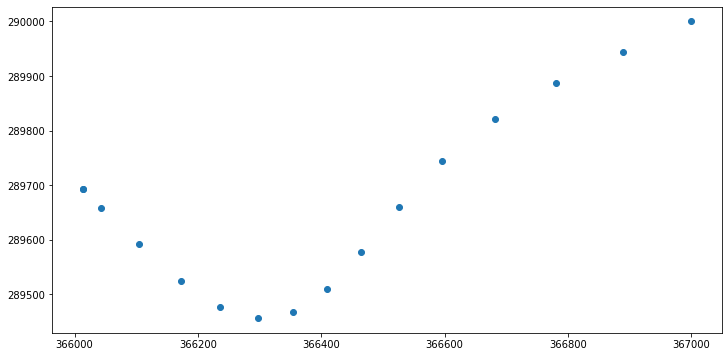

In [18]:
x,y,theta = (np.array(discretized_path_mm)).T
fig,ax = plt.subplots(figsize=(12,6))
print("Graph showing the nodes of the optimal path after discretizing and smoothing it:")
print("--------------------------------------------------------------------------------")
ax.scatter(x,y)

Since Thymio can be in any orientation at the start of the path, we decided to orient it towards the optimal path before starting the path following the algorithm. In fact, the controller is capable of doing this orientation; however, we found that it is more accurate to do it as a pre-step independent of the controller to reduce the possible error obtained in turning. 

The following cell calculates for the rotation angle needed by taking the difference between the initial orientation of Thymio (start_orientation) and the nominal orientation it should follow (start_orientation_nominal) and make sure it is compatible with the angle representation taken throughout the code (-pi, pi).

In [19]:
# Initial orientation of Thymio obtained from Aruco
start_Orientation = start_Orientation
print("Initial Orientation of Thymio: " + str(start_Orientation))

# Required orientation based on A* and discretized path
start_Orientation_Nominal = discretized_path[0][2]
print("Nominal Orientation of Thymio: " + str(start_Orientation_Nominal))

#Required angle of rotation 
rotation_angle_needed = start_Orientation_Nominal - start_Orientation

# check if the angle is between [-pi,pi], otherwise correct it 
if(abs(rotation_angle_needed))>math.pi:
    rotation_angle_needed = rotation_angle_needed % math.pi 

print("Rotation angle needed: " +str(rotation_angle_needed))

Initial Orientation of Thymio: -1.610775013918186
Nominal Orientation of Thymio: -2.6791967642187746
Rotation angle needed: -1.0684217503005886


# Handling Thymio's Orientation  <a class="anchor" id="Handling_Thymio_Orientation"></a>

<div style="text-align: justify"> To increase the precision of following the path, Thymio is first oriented towards the angle of the first node. Similarly, upon reaching the goal, Thymio has to orient to the orientation of the global goal. To obtain this rotation, we use the function 'angle_adjustment'. </div>

<br>

<div style="text-align: justify"> To implement this function, Thymio's motors were set at speeds 100 and -100 to obtain a rotatory movement. Then, time in ms was recorded when Thymio rotated 360, 270, 180 and 90 degrees. The relationship between the time and the angle was exactly linear, as shown in the table below. Therefore, this function orients Thymio using a fixed ratio between time and angle: $ ratio = \frac{2500}{90} $. </div>
<br>
<div style="text-align: justify"> To calculate time, we used time.time function and we continuously recorded the difference in time since the rotation began. This approach was specifically used because, in this way, the time recorded is a real time. When time.sleep function was used in a for loop, the time became dependent on the laptop's processing speed because of the existence of the for loop, so it did not perform the same way on different devices (as mentioned in the document uploaded on moodle).  </div>

<img src = "images\orientation.png" width = 200 height = 200>

<div style="text-align: center"> Recorded values of angles versus time </div>

In [20]:
def angle_adjustment(rotation_angle_needed):
    """
    This function rotates Thymio to a specific angle using a linear relationship between time and and angles.
    It handles the time as follow: 
    - record time right before rotating
    - record time as it is rotating and calculate difference relative to the starting time
    - keep rotating until the difference is the precalculated time required to rotate to reach the required angle
    
    
    rotation_angle_needed is the angle Thymio needs to rotate in radians. Positive angle is anticlockwise. 
    """
    #angle in radians is converted to degrees usng the math library
    angle_deg = math.degrees(rotation_angle_needed)
    
    #the required time to rotate tp reach the required angle is calculated using the ratio 2500/90 
    wait=round(abs(angle_deg)*(2500/90))
    
    #Start time is recorded
    t0 = time.time()*1000
    #One reading of the current time is recorded
    t1 = time.time()*1000
    #The initial difference between both times is 0
    dt = t1-t0
    
    #loop until the wait time is reached
    while(dt < wait):
        #function orients Thymio is used to rotate Thymio while handling the direction of rotation 
        orient_Thymio(angle_deg)
        #record the current time at each loop
        t1 = time.time()*1000
        #record the diference between the cureent time and the starting time
        dt = t1-t0
    #stop Thymio after thymio is rotated for the required time
    stop_Thymio()

# Camera Variance Calculation <a class="anchor" id="CameraCalibration"></a>

<div style="text-align: justify">  The variance of the camera readings needs to be calculated to use the Kalman filter. Therefore, an experimental setup was set to calculate the required variance. As shown in the photos below, two A3 papers were printed with straight lines. The total length of the path was close to 80 cm, and we marked 10 cm steps on the papers. </div> 

<table><tr>
<td> <img src="images\setup1.png" alt="1" style="width: 250px"/> </td>
<td> <img src="images\setup2.png" alt="2" style="width: 250px"/> </td>
</tr></table>

<div style="text-align: center"> Experimental Setup </div> 

<br>

<div style="text-align: justify"> Using this setup, Thymio was placed at every 10 cm mark (0 to 80 cm) and the camera readings were recorded in pixels. These pixels were transformed to cm values, and the variance was calculated as shown in the table below. These calculations were done based on the movements in the y-direction, but the variance is assumed to be the same for x and y directions as both are linear motions.  </div> 

<img src = "images\camera_xy.png" width = 500 height = 500>
<div style="text-align: center"> Variance calculations for the linear movements measured by the camera </div> 

<br>
<div style="text-align: justify"> The camera is used to read x and y coordinates as well as the angle values. Hence, a similar experiment was done to calculate the variance of the camera's angles readings. For the angles, Thymio was placed at a specific location and rotated at 0, 45, 90, and 180 degrees. At each of these locations, the camera readings were recorded, and the variance was calculated the same way as what was done in the linear motion.  </div> 

<img src = "images\camera_theta.png" width = 400 height = 400>

<div style="text-align: center"> Variance calculations for the camera's angular readings </div> 

# Variance Calculations for the Motion Model <a class="anchor" id="MotionModelVariance"></a>

<div style="text-align: justify"> Similar to the case of the camera, the Kalman filter also needs the motion model's variance. To obtain such variance, a similar experiment to the one done for the camera was performed. Using the same setup as before, the variance for the linear movements in the motion model was obtained by using the motion model alone to move Thymio for 15 cm in the y (vertical) direction. After it stopped, the actual distance travelled was read on the labelled A3 sheets and recorded. This step was then repeated 14 times, and the variance was calculated using the difference between the readings obtained to the 15 cm. The detailed calculations are found below. This experiment was done after the motors calibration was done to ensure that Thymio moves as straight as possible. Moreover, similar to the camera's case the variance obtained for the movement in the y-direction was assumed to be the same for both the x and y directions.  </div>
<br>
<img src = "images\motionmodel_xy.png" width = 400 height = 400>

<div style="text-align: center"> Variance calculations for the motion model's linear readings </div>

<br>
<div style="text-align: justify"> For the angular measurement of the motion model, Thymio was instructed to rotate to a specific angle, and the values of the actual movements were recorded and compared to the specific angle given to the motion model. However, the actual rotation was not measured using a protractor: it was measured using the camera. The camera had a variance of around 0.0013 in angular readings, which is better than the precision of the protractor (1 degree = 0.017 rad). This experiment was tried for 45-degree angle and 90-degree angle and five trials each. The details of the calculations can be found in the table below. </div>

<br>
<table><tr>
<td> <img src="images\mm_theta1.png" alt="1" style="width: 450px"/> </td>
<td> <img src="images\mm_theta2.png" alt="2" style="width: 450px"/> </td>
</tr></table>

<div style="text-align: center"> Variance calculations for the motion model's angular readings </div>

# Using the Extended Kalman Filter for Localization

To localize the robot in a given map, we need 2 main components. the first is a mathemetical model describing the robot's movement and evolution of position throughout time, and the second is a measurement model, which acts like an observer in control theory, utilizing sensor measurements to correct the mathemetical motion model estimate. This is mainly due to the fact that mathemetical models are usually generated under Ideal circumstances, failing to account for real-life physical limitations, from motor input saturation, wheel slippage, friction, the fact that no 2 motors execute a motion command the same way, even when calibrated, amongst many other limitations.

Mathemetical Motion Model Derivation:

The motion model should, in essence, describe the agent we're working with. Since our agent is Thymio, a differential drive robot, the motion model corresponds to that of a differential drive.

It describes the evolution of 3 states, [x,y,orientation] of the robot, given the previous state and a set of inputs [v,w], corresponding to linear (mm/s) and rotational (rad/s) velocities respectively. The motion model is shown below:

 <img src = "images\motion_model_nonlinear.jpg" width = 430 height = 106><br>

An in-depth derivation of the motion model can be found on https://automaticaddison.com/how-to-derive-the-state-space-model-for-a-mobile-robot/, one of largest robotics educational blogs online.

However, We notice that the motion model of a differential drive robot is non-linear, and thus a typical Kalman filter, which only works on linear functions/systems, is not applicable. We need to convert the above model into a linear, discrete state-space formulation like shown below:

<img src = "images\linear_discrete_statespace.jpg" width = 299 height = 50><br>

We thus had to use an Extended Kalman Filter (EKF), which enables the Kalman Filter to be applied to systems that have nonlinear dynamics, like in the case of Thymio. With an EKF, we linearize the above motion model through the use of a Jacobian matrix. Our final state-space motion model thus becomes:

<img src = "images\ekf-motion-model.jpg" width = 600 height = 100><br>

Note that the right-most term is called 'process noise', and is added to mathematically represent the deviation of our motion  odel from real-life state evolution, due to unpredictable errors, like the ones discussed at first. I  our implementation, we take the process noise to follow a Normal distribution with a mean of zero and covariance matrix Q, that we compute empirically, discussed in earlier sections.


Measurement Model:

Typically, when a mobile robot moves around, we gather measurements from sensors to know the state / robot pose. A measurement model, however, uses whatever predicted state (by the motion model) we're in, to estimate the sensor measurement value. The measurement model is crucial, as it can help in cases of very noisy sensors, or even when a sensor breaks or gives outlier erraneous data! It enables us to predict what the sensor measurement should've been, and react correspondingly.

An in-depth derivation of the measurement model can be found on https://automaticaddison.com/how-to-derive-the-observation-model-for-a-mobile-robot/. The final model is:

<img src = "images\observation-model.jpg" width = 184 height = 59><br>

with H being the Identity matrix in our case:

<img src = "images\H.jpg" width = 181 height = 112><br>

And 'w' being the sensor measurement noise, assumed to follow a Normal distribution with a mean of zero and covariance matric R, computed empirically and discussed in earlier sections.


We introduce the above 2 models, alongside the Camera measurements, into a typical Kalman filter algorithm to have an updated pose estimation of our robot. The code, inspired from https://automaticaddison.com/how-to-derive-the-observation-model-for-a-mobile-robot/ and modified/segmented to go with the logic of our Finite State Machine of the Main Loop, is displayed below.

In [21]:
def getB(yaw, deltak):
    """
    Calculates and returns the B matrix
    3x2 matix -> number of states x number of control inputs
    
    """
    B = np.array([[math.cos(yaw)*deltak, 0],
                  [math.sin(yaw)*deltak, 0],
                  [0, deltak]])
    return B

# Motion model dynamics
A = np.array([[1.0,  0,   0],
              [  0,1.0,   0],
              [  0,  0, 1.0]])  

# Motion model noise (mean = 0)
process_noise = np.array([0,0,0]) 

# Sensor noise (mean = 0)
sensor_noise_w_k = np.array([0,0,0]) # sensor noise mean = 0

# Measurement model prediction
H_k = np.array([[1.0,  0,   0],
                [  0,1.0,   0],
                [  0,  0, 1.0]]) 


# Based on empirical testing, values in mm
# Variance on the x position 
q_x = 3.2
# Variance on the y position  
q_y = 3.2 
# Variance on theta
q_theta = 0.048 

# State model noise covariance matrix Q_k
Q_k = np.array([[q_x,   0,   0],
                [  0, q_y,   0],
                [  0,   0, q_theta]]) 


# Camera Aruco Marker pairing and testing for pose estimation to get the variance
# Variance on the x position
r_x = 1.1 
# Variance on the y position
r_y = 1.1 
# Variance on theta
r_theta =  0.001 

# Sensor measurement noise covariance matrix R_k
R_k = np.array([[r_x,   0,    0],
                [  0, r_y,    0],
                [  0,    0, r_theta]]) 

# Initial state covariance matrix
# Used the r values since initial state is detected by the camera / Aruco pairing
P_k_minus_1 = np.array([[r_x,  0,   0],
                        [  0,r_y,   0],
                        [  0,  0, r_theta]]) 
                                               
                                               
Kp_alpha = 2 
Kp_beta = -0.5 
Kp_rho = 3 

In [22]:
def state_est_motion_model(state_estimate_k_minus_1, control_vector_k_minus_1, P_k_minus_1, dk):
    state_estimate_k = A @ (state_estimate_k_minus_1) + (getB(state_estimate_k_minus_1[2],dk)) @ (control_vector_k_minus_1) + (process_noise)
    
    # State covariance matrix
    P_k = A @ P_k_minus_1 @ A.T + (Q_k) 
    
    return state_estimate_k, P_k

def ekf(z_k_observation_vector, state_estimate_k, P_k): 
# z_k = [x,y,theta] from camera  
# Control_vector = output of controller_input
        measurement_residual_y_k = z_k_observation_vector - ((H_k @ state_estimate_k) + (sensor_noise_w_k))
    
        # Measurement residual covariance
        S_k = H_k @ P_k @ H_k.T + R_k 
        
        # Kalman gain
        K_k = P_k @ H_k.T @ np.linalg.pinv(S_k) 
        
        # Update state estimate for time k
        state_estimate_k = state_estimate_k + (K_k @ measurement_residual_y_k) 
        
        # Update the state covariance estimate for time k
        P_k = P_k - (K_k @ H_k @ P_k) 
        
        return state_estimate_k, P_k


# Control Law (Move-to-Pose)

The control law algorithm (Move-to-Pose) is based on the code "move_to_code.py" that can be found at the link:
https://github.com/AtsushiSakai/PythonRobotics/blob/master/Control/move_to_pose/move_to_pose.py .

<br>

Another source we have used is the assignment of an exercise session of the course "Autonomous Mobile Robots" given at ETHZ. The assignment, "Exercise 2 - Kinematics and control of a differential drive vehicle", can be found at the link: https://asl.ethz.ch/education/lectures/autonomous_mobile_robots/spring-2020.html .

This control technique takes a start position and a goal position as a set of coordinates (x and y) and an angle. Then, it uses them to calculate a linear and angular velocity as control outputs. 

<br>

The variables used in the control law algorithm are shown in the scheme below (Figure 1 of "Exercise 2 - Kinematics and control of a differential drive vehicle").

<img src="images\Controller_scheme.png" width="600" height="300">

More in detail:
* $ \rho $ is the distance between Thymio and the goal position (not necessarily the global one);
* $ \alpha $ is the difference between the current angle of Thymio and the angle it should have to reach the next goal;
* $ \beta $ is the angle between Thymio's position and the goal position plus the goal angle;
* $ v $ is Thymio's forward velocity, one of the outputs of the control law;
* $ \omega $ is Thymio's rotational velocity, one of the outputs of the control law.

We have adapted the control law so that it offers two different operation modes:
1. In the first mode, Thymio's forward velocity depends on the distance to the goal. The control law used in this mode is the following: <br> <br>
$ v = k_{\rho} \rho $ <br>
$ \omega = k_{\alpha} \alpha + k_{\beta} \beta $ <br> <br>
$ k_{\rho} $ , $ k_{\alpha} $ and $ k_{\beta} $ are gain values and have been tuned by trials and errors to obtain the best performance possible. Note that, as $ \alpha $ is defined counterclockwise and $ \beta $ is defined clockwise, $ k_{\alpha} > 0 $ and $ k_{\beta} < 0 $. <br> <br>

2. In the second mode, Thymio's forward velocity is constant for the whole path. The control law used in this mode is the following: <br> <br>
$ v = K_{V} $ <br>
$ \omega = k_{\alpha} \alpha + k_{\beta} \beta $ <br> <br>
$ k_{\alpha} $ and $ k_{\beta} $ are gain values, and $ K_{V} $ is the constant velocity. They have been tuned by trials and errors to obtain the best performance possible. Note that, as $ \alpha $ is defined counterclockwise and $ \beta $ is defined clockwise, $ k_{\alpha} > 0 $ and $ k_{\beta} < 0 $. <br> <br>

We have decided to implement the second operating mode as we are discretizing our path, and the goal we are giving to the controller is not necessarily the global one; especially if we are passing intermediate goals to the controller, we do not want Thymio to slow down when approaching the goal. We are actually using this second mode to control Thymio.

In [23]:
def control_law(state_estimate_k, x_goal, y_goal, theta_goal, adaptable_speed):
    
    """
    rho is the distance between the robot and the goal position
    alpha is the angle to the goal relative to the heading of the robot
    beta is the angle between the robot's position and the goal position plus the goal angle
    Kp_rho*rho and Kp_alpha*alpha drive the robot along a line towards the goal
    Kp_beta*beta rotates the line so that it is parallel to the goal angle
    
    """
    #the current position estimate (x,y and theta) from the filter is defined 
    x = state_estimate_k[0]
    y = state_estimate_k[1]
    theta = state_estimate_k[2]
    
    #the difference between current position and the next goal is defined. 
    #It is important to notice that the goal defined here is not necessarily the final goal. 
    #The goal is the next point on the discretised path 
    x_diff = x_goal - x
    y_diff = y_goal - y

    # Restrict alpha and beta (angle differences) to the range
    # [-pi, pi] to prevent unstable behavior e.g. difference going
    # from 0 rad to 2*pi rad with slight turn


    # rho, the distance to the goal, is calculated as the hypotenuse of the difference in positions between the 
    # robot and the next goal in x and y directions
    rho = math.sqrt(x_diff**2 + y_diff**2)
    
    # alpha is the calculated as the difference in angles between the current angle and the angle that it should 
    #  have to reach the next goal. It accounts for the multiples of 2*pi and resistricts the angle between -pi & pi
    # In this step, we calculate the angle diffrence between where the robot is going and its current position
    alpha = (math.atan2(y_diff, x_diff)
                 - theta + math.pi) % (2 * math.pi) - math.pi
    # the beta is calculating the difference the in angle to the goal (next node). Similar to alpha, 
    # multiples of 2*pi are accounted for and beta is resistricted between -pi and pi.
    # In this step, we calculate the angle needed to achieve the goal orientation
    beta = (theta_goal - theta - alpha + math.pi) % (2 * math.pi) - math.pi

    # There are two modes in our control, the linear velocity of the robot can either be constant or dependant on 
    # the distance to the goal. In the second mode, the controller decreases the speed as the robot is closer to
    # the goal to increase precision. However, the constant velocity mode is suffcient and precise enough for the 
    # robot to precisely reach the goal.
    
    # The mode choice is selected in this step according the "adaptable_speed" flag which is an input to the function
    if adaptable_speed:
        
    # In case of adaptable speeds, the linear velocity of the robot is caclulated as a predetermined gain multiplied 
    # by the distance to the goal. The gain value is different than the one used by the source to match our application
        v = Kp_rho * rho
    
    else:
    # In the case of a constant velocity, only a velocity of 55  mm/s is used 
        v = 55 
    
    # The angular velocity is calculated based on the previously defined angles beta and alpha with each of them 
    #multiplied by a gain. The gain values are different than the ones used by the source to match our application
    w = Kp_alpha * alpha + Kp_beta * beta

    # In this step, the direction of v is flipped when alpha is between pi/2 and pi or between -pi/2 and pi
    if alpha > math.pi / 2 or alpha < -math.pi / 2:
        v = -v

    # The control function returns the linear and angular velocities computed which will then be converted to Thymio 
    # speeds to be input to the motors
    return v,w

# Speed Conversion to Thymio Speeds

<div style="text-align: justify"> To convert from the output of the control to Thymio speeds, the differential drive robots model was used: <br>
$ v_r = \frac{2 v + \omega L }{2 R} $ <br>
$ v_l = \frac{2 v - \omega L }{2 R} $

Where:
* $ v_r $ is the speed in rad/s for the right motor;
* $ v_l $ is the speed in rad/s for the left motor;
* $ v $ is Thymio's forward velocity;
* $ \omega $ is Thymio's rotational velocity;
* $ L $ is the distance between the two Thymio's wheels;
* $ R $ is radius of Thymio's wheels.
    
The forward ($ v $) and rotational ( $ \omega $) velocities are used to calculate speeds in rad/s for each motor ($ v_r $ and $ v_l $). <br>
These values are then converted to Thymio speeds using a conversion ratio that was calculated experimentally (see the section below). </div>

### Conversion Ratio Calculations  <br>
<div style="text-align: justify"> To obtain the values of the conversion ratio for each motor, a mark was drawn on each wheel as shown below. The motors are then run at $ speed_{Thymio} = 200 $ for 20 s and the number of revolutions are counted. This process was repeated 5 times to reduce human error and an average value was considered for the rest of the calculations. The average number of revolutions/s is then converted to rad/s ($ \overline{speed_{rad/s}} $) and the conversion ratio is calculated as: <br>
$ conversion\:ratio = \frac{speed_{Thymio}}{\overline{speed_{rad/s}}} = \frac{200}{\overline{speed_{rad/s}}}$ <br><br>
The detailed calculation can be found in the table below. </div>


<table><tr>
<td> <img src="images\marked_wheel.png" alt="marked_wheel" style="width: 250px;"/> </td>
<td> <img src="images\conversion_ratio_calc.jpg" alt="conversion_ratio_calc" style="width: 250px;"/> </td>
</tr></table>

<div style="text-align: center"> Left: Marked wheel for calibration. Right: Conversion Ratio detailed calculations. </div>

In [24]:
def convert_to_motor_speed(v , w, R, L, conv_ratio_right, conv_ratio_left): 
    """
    In this function, the controller's linear and angular velocities are converted to rad/s velocities and then
    to Thymio speeds. The equations used in this function are for the differential drive robots and are 
    obtained from this lecture video (https://youtu.be/aE7RQNhwnPQ)
    
    R is wheel radius 
    L is length of the base between the two wheels
    
    Each wheel has a conversion ratio from rad/s to Thymio which are obtained experimentally as discussed 
    in the notes markdown 
    """
    
    # in this step, the rad/s velocities of each motor is calculated 
    vr = (2*v + w*L)/(2*R) # right motor speed
    vl = (2*v - w*L)/(2*R) # left motor speed
    
    # in this step, the previous velocitires are converted to thymio speed
    vr_thymio = vr * conv_ratio_right
    vl_thymio = vl * conv_ratio_left
    
    # The function returns Thymio speeds that are directly fed to the robot's motors
    return vr_thymio, vl_thymio

# Functions Communicating With Thymio

In [ ]:
import tdmclient.notebook
await tdmclient.notebook.start()

In [ ]:
@tdmclient.notebook.sync_var
def motors(left,right):
    """
    This function moves Thymio according to the inputs of values for the left and right motors
    """
    global motor_left_target, motor_right_target
    motor_left_target = [left]
    motor_right_target = [right]

In [ ]:
@tdmclient.notebook.sync_var
def orient_Thymio(angle):
    """
    This function rotates Thymio at 100 and - 100 or -100 and 100 according to the sign of the input angle. 
    Positive angles means anticlockwise rotation
    """
    global motor_left_target,motor_right_target
    if(angle > 0):
        motor_left_target = -100
        motor_right_target = 100
    if(angle < 0):
        motor_left_target = 100
        motor_right_target = -100

In [ ]:
@tdmclient.notebook.sync_var
def stop_Thymio():
    """
    This function stops Thymio by giving the motors 0 values
    """
    global motor_left_target,motor_right_target
    motor_left_target = 0
    motor_right_target = 0

In [ ]:
@tdmclient.notebook.sync_var
def print_prox_value(num):
    """
    This function returns the value of proximity sensors. The choice of sensor to read is determined by the input
    """
        return prox_horizontal[num]

# Local obstacle avoidance

In the design phase of the local obstacle avoidance mode, we concentrated on four main aspects: 
1. When to enter into local obstacle avoidance mode;
2. How to interpret the sensor readings and how to use these values to make Thymio avoid the obstacle, to prevent some unwanted situations and deviate as little as possible from the optimal path previously computed;
3. How to exit from local obstacle avoidance mode;
4. How to translate from local obstacle avoidance mode to global path following mode (the one in which Thymio was before detecting an obstacle).
    
<br>

### 1 - Condition to enter into local obstacle avoidance mode <br>
<div style="text-align: justify"> In deciding when to enter into local obstacle avoidance mode, we have taken into account that Thymio may detect static obstacles during the optimal path following phase, as also the static obstacles are three-dimensional. To avoid entering into local obstacle avoidance mode in these situations, we have chosen weights associated with each proximity sensor, giving more weight to the central sensors. This is based on the fact that the optimal path is chosen taking into account static obstacles, and therefore Thymio will not move pointing straight to a static obstacle: if something is detected by the central sensor and is quite close, it is probably an added obstacle that should be avoided into local obstacle avoidance mode. The scheme LOA-1 clarifies this concept: the blue cross is the start node, the green cross is the goal node, the black obstacles are static, while the dark red one is added after the computation of the optimal path (that is shown, dotted, in dark blue). In situation 1, the right lateral sensor of the Thymio detects an obstacle, but we do not want to enter into local obstacle avoidance mode as the optimal path is already computed to avoid that obstacle. In situation 2, At least three sensors of the Thymio detects an obstacle, and in this case, we want to enter into local obstacle avoidance mode: Thymio is directly approaching the obstacle, and therefore this cannot be a static one (if this were a static one, the optimal path would have been different).</div>

<img src="images\IMG_1627.jpg" width="600" height="300">
<div style="text-align: center"> Scheme LOA-1: when to enter into local obstacle avoidance mode </div>

<br>

### 2 - Interpretation of the sensor reading to make Thymio avoid the obstacle inside local obstacle avoidance mode <br>
<div style="text-align: justify"> For what concerns the local obstacle avoidance mode behaviour, we decided to follow the obstacle to avoid collisions and direct Thymio to the goal as soon as the direction to the goal is free again. The obstacle avoidance strategy on which we based local obstacle avoidance mode is depicted in the scheme LOA-2. </div>
    
<img src="images\IMG_1637.jpg" width="600" height="500">
<div style="text-align: center"> Scheme LOA-2: obstacle avoidance strategy on which we based local obstacle avoidance mode </div>

<br>

<div style="text-align: justify"> The situation depicted in the upper part of the scheme represents the start of the obstacle avoidance mode: Thymio is directly facing a dynamic obstacle (that is, an added obstacle), and it has an orientation $ \theta_{Thymio} $. The angle that Thymio should have to reach the goal (next goal of the controller, not necessarily the global one) without rotations is $ \theta_{dir} $ and is recomputed every time the robot moves. At this point, Thymio starts following the obstacle keeping it on the right to avoid hitting it until we reach the situation depicted in the lower part of the scheme. At this point, $ \theta_{Thymio} = \theta_{dir} $, and the sensors do not detect any obstacle: Thymio can exit from obstacle avoidance mode and starts following the optimal path again. </div>
    
<div style="text-align: justify"> We implemented a few modifications to try to obtain the most efficient behaviour possible. First of all, the side in which Thymio follows the obstacle (left or right) is not decided a priori, but it is based on the sensor reading. The concept is shown in the scheme LOA-3: in situation 1, Thymio detects an obstacle using the right-hand-side sensors (and the central one), and it, therefore, approaches the obstacle keeping it to the right. Conversely, in situation 2, Thymio detects the obstacle using the left-hand sensors (and the central one) and therefore decides to approach the obstacle keeping it on the left. This prevents the robot from following long obstacles on the wrong side in all the situations in which Thymio can determine whether it is almost at one of the extremities (in all other cases, it is impossible to determine the shortest side without moving the robot). </div> 

<br>
    
<img src="images\IMG_1628.jpg" width="800" height="300">
<div style="text-align: center"> Scheme LOA-3: choice of the most efficient side in which Thymio follows the obstacle </div>

<br>

<div style="text-align: justify"> We had also to consider the case in which Thymio detects a static obstacle while it is following the added obstacle; if the robot passes in between the two objects, we want it to continue following the added obstacle and not the static one. To obtain this, Thymio can choose in which direction to follow an obstacle but cannot change it later on during local obstacle avoidance. This concept is depicted in the scheme LOA-4: the rectangular obstacle is the added one, and Thymio starts following it, keeping it to the right. When the robot detects the second obstacle (that could be a static one), we do not want it to start following the second obstacle but to continue keeping the first obstacle to the right. Note that the numbers refer to successive time instants. Thymio, of course, still reacts and avoids both obstacles, but it only follows the first one it detected. This helps when the added obstacle is too close to another obstacle that was already on the map.</div>
    
<img src="images\IMG_1630.jpg" width="400" height="400">
<div style="text-align: center"> Scheme LOA-4: the obstacle to follow is kept fixed even if another obstacle is detected </div>

<br>
    
    
<div style="text-align: justify"> We have improved the obstacle avoidance strategy introduced before to make our code more robust. When calculating $ \theta_{dir} $, we initially considered the next goal of the controller (that is not necessarily the global one), but as the path is discretized and the nodes are quite frequent, there is the possibility that, while avoiding the obstacle, Thymio leaves the next goal behind. This situation is depicted in the scheme LOA-5.  </div>

<img src="images\IMG_1638.jpg" width="600" height="500">
<div style="text-align: center"> Scheme LOA-5: Possible failure of the obstacle avoidance strategy </div>

<br>

<div style="text-align: justify"> This situation is very similar to the one depicted in the scheme LOA-2, but this time the next goal is closer, and it happens to be inside the obstacle. By the time Thymio rounds the obstacle to avoid hitting it, the next goal is at the robot's right (see LOA-5, bottom scheme). Since we do not want a $ \theta_{dir} = 0 $ (this will cause Thymio to try to enter inside the obstacle), we decided to take into account not only the next node/goal but the first five nodes on the optimal path to compute $ \theta_{dir} $. The choice of five nodes is dependent on two parameters. First, an assumption about the maximum size of the dynamic obstacle that Thymio might face in such a way that the minimum distance covered by these five nodes is more than the maximum distance covered by the obstacle. The second parameter is related to the discretization parameter 'h' since it represents the distance between nodes. Therefore, the number of nodes here is dependent of 'h' and both parameters were chosen concurrently to match the map and the obstacle size assumption. </div>

<br>

### 3 - Conditions to exit from local obstacle avoidance mode
As indicated in the previous paragraph, two conditions must be satisfied to exit from local obstacle avoidance mode:
* We want the direction to the goal to be free again. We check the satisfaction of this condition using angles, and we also take into account some margin: we do not want a perfect placement since the controller can take care of minor corrections. We defined $ \theta_{opt} = \theta_{dir} - \theta_{Thymio} $ and we want $ \theta_{opt} < threshold $ ($ threshold $ has been carefully tuned: it has to be high enough to avoid that Thymio "misses" the correct angle while rotating, but not too high as we want a certain precision in the alignment to the correct angle);
* We want the weighted sum of the sensor readings computed before to be lower than a specified threshold to avoid exiting from local obstacle avoidance mode just to enter in the same mode immediately after: therefore, if two obstacles are very close, we are considering them as a single obstacle.
    
<br>

### 4 - Transition from local obstacle avoidance mode to global path following mode <br>
<div style="text-align: justify"> The controller performes the transition between local obstacle avoidance mode and global path following mode. It brings back the Thymio to the optimal path once the added obstacle has been avoided. The way in which the optimal theta is calculated ensures that when Thymio exits the local obstacle avoidance mode, its orientation will be close enough to the one of the optimal path so that the control takes it easily back to the optimal path. When we exit the local obstacle avoidance mode, we go straight for five iterations to avoid sensing the same obstacle again, and we then update the position of the next goal (not necessarily the global one), taking into account that we may have skipped some nodes during the local obstacle avoidance. </div>

<br>

### Local obstacle avoidance mode at work <br>
<div style="text-align: justify"> We tested the local obstacle avoidance mode introducing an obstacle after the optimal path had been computed and Thymio had started following the optimal path thanks to the controller. An experimental situation we tested can be seen in table LOA-6. The initial setup can be seen in the leftmost picture: only static obstacles are present, and these objects are taken into account to generate the optimal path (that can be seen in green); Thymio starts following the optimal path. At a certain point (middle-left picture), we introduce a new obstacle (a static Thymio), and the robot enters the local obstacle avoidance mode, deviating from the optimal path. Thymio keeps the obstacle on the right and circles it (middle-right picture) until the stopping conditions are satisfied. Then, another obstacle is introduced: Thymio avoids it, exits from local obstacle avoidance mode, and the controller brings it back to the optimal path.

</div>

<table><tr>
<td> <img src="images\obs1.png" alt="1" style="width: 250px"/> </td>
<td> <img src="images\obs2.png" alt="2" style="width: 250px"/> </td>
<td> <img src="images\obs3.png" alt="4" style="width: 250px"/> </td>
<td> <img src="images\obs4.png" alt="3" style="width: 250px"/> </td>
</tr></table>


<div style="text-align: center"> Table LOA-6. Leftmost image: initial setup, with optimal path. Middle-left image: Thymio detects an added obstacle and enters into local obstacle avoidance mode, deviating from the optimal path. Middle-right image: local obstacle avoidance in progress. Rightmost image: after avoiding the added obstacles, Thymio returns to the optimal path. </div>

In [ ]:
@tdmclient.notebook.sync_var
def obstacle_avoidance(state_estimate_k, theta_opt):
    #global state_estimate_k, prox_horizontal, motor_left_target, motor_right_target, prox_ground_delta,R,L,conv_ratio_right,conv_ratio_left,P_k_minus_1,control_vector_k_minus_1,dk,time_elapsed,new_node,theta_opt,threshold,stop,direction_flag
    global prox_horizontal, motor_left_target, motor_right_target, prox_ground_delta,R,L,\
    conv_ratio_right,conv_ratio_left,threshold,stop,direction_flag, v_obs, w_obs, direction_to_be_selected
    
    # We are giving differents weights to the readings of the various sensors. To do so, we define the weights
    # associated to the different sensors. The format of the names of the weights is wnx, where n is the sensor
    # number (based on the Thymio Cheat Sheet) and x could assume values 'l' (that stands for left) and 'r' (that
    # stands for right). The wnl weights indicates how the sensor readings influences the speed of the left wheel,
    # and the wnr weights indicates how the sensor readings influences the speed of the right wheel
    w0l =  1
    w1l =  2
    w2l = - 2
    w3l = - 2
    w4l = - 1
    w0r = - 1
    w1r = - 2
    w2r = 2
    w3r = 2
    w4r = 1
    
    # We define the variable weighted_sum, that is used to decide whether it is necessary to enter in the local
    # obstacle avoidance mode and to exit from the obstacle avoidance mode. weighted_sum is a weighted sum of the
    # readings of the various sensors (from sensor 0 to sensor 4), and the weights are decided so as to give
    # the highest weight to the central sensor (2), medium weight to sensors 1 and 3 and lowest weight to the
    # lateral sensors (1 and 4). We used this approach since we do not necessarily want to enter obstacle avoidance
    # mode when Thymio detects an obstacle far away with the lateral sensors: these obstacles may be static, and
    # may have been taken into account by the path planning algorithm already. Vice versa, if Thymio is directly
    # pointing to an obstacle, this is probably a dynamic one, as the path planning wouldn't have decided a path
    # that directly points towards a static obstacle
    weighted_sum = print_prox_value(0) * 1 + print_prox_value(1) * 3 + print_prox_value(2) * 10 +  print_prox_value(3) * 3 + print_prox_value(4) * 1
    
    print("Angle difference " + str(theta_opt - state_estimate_k[2]))

    # We now check if we have to exit the local obstacle avoidance mode. We only exit if two conditions are
    # satisfied:
    # 1) the difference between the optimal angle and the current state is less than the threshold 
    # 2) the weighted sum of the sensors is less than the predefined threshhold 
    if(abs(theta_opt % (2*math.pi)) < threshold and weighted_sum <= threshold_weighted_sum):
        print("Directly stopped !!! ")
        #once inside the exit condition, the stop flag is turned on and the linear and angular velocities are set  
        #to 0. these values of velocities do not affect thymio because once the obstacle avoidance mode stops, 
        #the controller works
        stop = 1
        v_obs = 0
        w_obs = 0
        
        
    if(stop == 0):
       #calculations of the weighted summation of the sensor values
        y1 = (w0l * prox_horizontal[0] + w1l * prox_horizontal[1] + w2l * prox_horizontal[2] + w3l * prox_horizontal[3] + w4l * prox_horizontal[4])//20
        y2 = (w0r * prox_horizontal[0] + w1r * prox_horizontal[1] + w2r * prox_horizontal[2] + w3r * prox_horizontal[3] + w4r * prox_horizontal[4])//20   

        # if both readings are zero (no obstacle detected), continue turning according to the direction flag that was
        # already defined. This is done to follow the obstacle is the direction it detected.
        if (y1 == 0 and y2 == 0):
            if (direction_flag == 1):
                y1 = 100
                y2 = 200
            else:
                y1 = 200
                y2 = 100
        #if y1 and y2 are not 0, then a value of 50 is added to them to ensure that that Thymio still moves if the values
        #are too small
        else:
            y1 = y1 + 50
            y2 = y2 + 50
        #in this step, the direction is chosen based on the values of y1 and y2. Also, the direction is only set once
        # it only changes when everything is reset
            if (y1 >= y2 and direction_to_be_selected):
                # 1 means left
                direction_flag = 1
                direction_to_be_selected = False
            elif (y1 < y2 and direction_to_be_selected):
                direction_flag = 0
                direction_to_be_selected = False
        
        #in this step, the speed is limited to 200. At first, the speeds were limited at 700 because we found out
        #that Thymio's speeds saturates at around 700. So, the motion model was taking much higher speed values that 
        #what thymio was actually using. So, to avoid miss-estimaition of the positions, an upper bound of the speed 
        #was set. Afterwards, this limit was decreased to 200 because it was found empirically that some precision in
        #the motion model was lost at higher speeds
        if y1 > 200:
            y1 = 200
        if y2 > 200:
            y2 = 200
        if y1 < -200:
            y1 = -200
        if y2 < -200:
            y2 = -200
            
        motor_left_target = y1
        motor_right_target = y2
        #in this step, thymio speeds is backsubstituted in the equations of the function "convert to thymio speeds"
        #these values are used as an input to filter to estimate the position instead of the control outputs. 
        #This is done because the controller is not used inside the obstacle avoidance mode but the kalman filter 
        #still works taking inputs from the motion model and the camera readings
        VL = motor_left_target/conv_ratio_left 
        VR = motor_right_target/conv_ratio_right

        v_obs = (R * VL + R * VR)/2
        w_obs = (R * VR - R * VL)/L
    
    return v_obs, w_obs

# Main code 

## Detecting Thymio continuously using Aruco marker

We have already explained how the detection of Aruco is done. The below function is very similar to the one previously introduced, with minor changes that do not affect the logic behind the process.
1. The video stream will be turned on, and the frame will be taken in the main loop; therefore, this function reads the image as an input instead of reading a pre saved image (as done in the first function.)
2. Here, we are only looking for one Aruco, the one corresponding to Thymio, without checking for the Aruco corresponding to the goal.
3. Since the camera will be taking frames continuously and could give erroneous output and since lighting conditions change while Thymio is moving, the detection of Aruco might fail in some extreme conditions. Also, if the camera was obstructed, we do not want this function to result in outlier measurements. This is dealt with in the main loop by diregarding the camera measurement and depending only on the motion model. 



In [25]:
def DetectArucoVideo(cXTest,cYTest,ThetaTest,frame):
    # define names of each possible ArUco tag OpenCV supports
    ARUCO_DICT = {
    "DICT_6X6_50": cv2.aruco.DICT_6X6_50,
    "DICT_6X6_100": cv2.aruco.DICT_6X6_100,
    "DICT_6X6_250": cv2.aruco.DICT_6X6_250,
    "DICT_6X6_1000": cv2.aruco.DICT_6X6_1000,
    "DICT_7X7_50": cv2.aruco.DICT_7X7_50,
    "DICT_7X7_100": cv2.aruco.DICT_7X7_100,
    "DICT_7X7_250": cv2.aruco.DICT_7X7_250,
    "DICT_7X7_1000": cv2.aruco.DICT_7X7_1000,
    }

    # verify that the supplied ArUCo tag exists and is supported by
    # OpenCV
    if ARUCO_DICT.get('DICT_6X6_1000', None) is None:
        print("[INFO] ArUCo tag of '{}' is not supported".format(
            'DICT_6X6_1000'))
        sys.exit(0)


    # load the ArUCo dictionary, grab the ArUCo parameters, and detect the markers

    arucoDict = cv2.aruco.Dictionary_get(ARUCO_DICT['DICT_6X6_1000'])
    arucoParams = cv2.aruco.DetectorParameters_create()
    height, width, _ = frame.shape
    
    # detect ArUco markers in the input frame
    (corners, ids, rejected) = cv2.aruco.detectMarkers(frame, arucoDict, parameters=arucoParams)

    # verify *at least* one ArUco marker was detected
    if len(corners) > 0:
        # flatten the ArUco IDs list
        ids = ids.flatten()
        # loop over the detected ArUCo corners
        for (markerCorner, markerID) in zip(corners, ids):
            # extract the marker corners (which are always returned in
            # top-left, top-right, bottom-right, and bottom-left order)
            corners = markerCorner.reshape((4, 2))
            (topLeft, topRight, bottomRight, bottomLeft) = corners
            
            # convert each of the (x, y)-coordinate pairs to integers
            topRight = (int(topRight[0]), int(topRight[1]))
            bottomRight = (int(bottomRight[0]), int(bottomRight[1]))
            bottomLeft = (int(bottomLeft[0]), int(bottomLeft[1]))
            topLeft = (int(topLeft[0]), int(topLeft[1]))
            theta = ((np.arctan2((topRight[1]-topLeft[1]),(topRight[0]-topLeft[0])))-((math.pi)/2))*-1
            
            # Take care of the angle representation
            if theta > math.pi:
                theta = theta - 2*math.pi

            # compute the center (x, y)-coordinates of the ArUco Marker
            cX = int((topLeft[0] + bottomRight[0]) / 2.0)
            cY = height - (int((topLeft[1] + bottomRight[1]) / 2.0))
    else:
        # If nothing is detected, give back previous values
        cX = cXTest
        cY= cYTest
        theta = ThetaTest
        
    return [cX,cY,theta]

As already mentioned a couple of times, the coordinates obtained from images are in pixel and to be able to pass them to the controller, a conversion to 'mm' is required. For that purpose, the below function is used on the output of the "detectArucoVideo" function to make sure all coordinates are compatible in dimension.

In [26]:
def Pixel_to_mm(z_k_measurement):
    cX = z_k_measurement[0]
    cY = z_k_measurement[1]
    
    new_x = ((cX -  start_coord_X)*real_width/warped_width) + discretized_path_mm[0][0]
    new_y = ((cY - start_coords_Y)*real_height/warped_height) + discretized_path_mm[0][1]
    
    return [new_x,new_y,z_k_measurement[2]]

## Sampling rate 

The first thing to note about our main loop is the sampling time chosen. In fact, this sampling time is based on the Thymio proximity sensors frequency, the camera rate and its processing time, and the motion model and its processing time. 


Starting with the proximity sensors, the frequency based on Thymio datasheet is 10Hz which corresponds to a 0.1s sampling time. This value is the fastest that we can sample and sets a lower limit on the sampling rate. However, when working on the local obstacle avoidance and testing the sensors at 0.1s, the sensors did not always update their values correctly. We found that if the sampling is set at 0.15s as to give some more margin and not be at the limit of the sampling frequency, the sensors are more accurate and the reaction to the obstacles is fast enough. Therefore, the sampling rate was set at 0.15s.

Given this sampling rate, we tested for the processing time of the motion model. It was found to be 0.02s at maximum; a sampling rate of 0.15s is more than enough.

Regarding the camera, it can provide 30 frames per second which is equivalent to 0.033 seconds. We still have to account for the processing time required to warp the perspective and detect the Aruco in the frame. We tested for this processing time which was found to be around 0.04s at maximum. The sampling rate of 0.15s is again enough. However, when testing the camera, results showed that sampling the camera at this rate still gave wrong results in the detection of Aruco at some instances. Therefore, we tried to sample the camera every two iterations of the loop (i.e. at 0.3s). This change decreased the wrong readings significantly, thus it was adapted. This is reflected in the state machine where the camera measurement is only taken if the sample camera flag is true, meaning two iterations have already passed since the last camera sampling.


## Initialization and first rotation 

The first state is an initialization state of some variables that need to be initialized before starting the main loop. The initial control values are set to zero, the initial state estimate to the start position of Thymio, the first goal node to the second node in the discretized path, along with some flags used to transition between states and to manage the local obstacle avoidance algorithm. The meaning of each flag is commented in the code.

The second state consists of an initial rotation of Thymio. As mentioned earlier, we decided to rotate Thymio to the nominal angle of the optimal path before starting our main loop instead of letting the controller handle this rotation (even though it is capable of doing and this was tested) for better precision in the angle of Thymio and to avoid starting the "path following" with an initial error in orientation due to the overshoot of the controller. 

## Finite State Machine

<br>The high level finite state machine of our project is shown in the figure below.
<img src="images\StateMachine.jpeg" width="400" height="500">

Our main function is best explained by splitting it into two scenarios. The first is the perfect scenario where no local obstacle avoidance is needed, and Thymio can exactly follow its optimal path. The second introduces the local obstacle avoidance part, where along the optimal path, Thymio is confronted with some dynamic obstacles that it needs to avoid.

1. No local obstacle avoidance:
<br>In a perfect scenario, the position of Thymio is first estimated by the state estimation model by relying on the previous control values and previous Thymio location. 
<br><br>If the camera is to be sampled at this iteration, the position of Thymio is obtained from the camera measurement. Here, we introduced another check of the position obtained by the camera by comparing it to the position given by the state estimation model. The camera measurement was disregarded whenever the difference between the two was greater than 1m which is not realistic given the size of our map.
<br> Whenever the position given by the camera is accepted, the extended Kalman filter is used to correct our state estimate.
<br> <br> At this point, the most current state estimate is available; it could be passed to the controller, which should also be given the next point to reach to calculate the optimal velocities. Every next node on the path is considered as an intermediary goal and are referred to in the function as "goal_pose" not to be confused with the global goal or final destination. At every iteration, the goal pose is considered as reached if Thymio (state estimate) is at an epsilon distance from this goal pose. Epsilon was chosen to be 10mm = 1cm since the optimal path already went through discretization and smoothing, and we want Thymio to be very accurate in following it. Having both the current position of Thymio and the goal to reach, the controller can now output the linear and angular velocities required; these will be converted into Thymio speeds and sent as commands to Thymio. 
<br><br> An important note should be made regarding the time during which these speed commands are set. In fact, the state estimation model follows a sampling time of "dk", during which Thymio will be performing the control commands in order to estimate the next position of Thymio. However, this does not take into consideration the processing time of the loop, and Thymio will end up moving more than "dk" time before getting new commands, making the state estimation less accurate. To account for this processing time as much as possible, we decided to record the time it takes for the loop to process "dt". Then, we let Thymio run for "dk-dt" time before looping again, knowing that the process of the loop will take approximately "dt" time and the total time of running of Thymio on the last control speed would be "dk" in total, matching the state estimation model. This process continues until the global goal is reached. At this time, and by observation through numerous tests, it happens that Thymio does not reach the goal position in the exact correct orientation. Therefore, and to make Thymio park correctly facing the Rolex building, we make use of our function to rotate Thymio by a certain angle which will be the difference between the current orientation of Thymio and the orientation it should have at the goal.
<br><br>
2. With local obstacle avoidance:
<br>Whenever the entering conditions as specified by the local obstacle avoidance algorithm are satisfied, we move to a local obstacle avoidance state where the algorithm is responsible for setting the velocity commands to send to Thymio instead of the controller. 
<br><br> As explained previously, this algorithm relies on an angle difference in its exiting condition, and this angle difference should be given to it as an input. To be representative of the optimal path, the angle difference is given as the difference between the current position of Thymio and an average value. This average value is taken as the average of the orientation of the next five nodes on the path. The reason behind this is to exit the obstacle avoidance state at an angle that is as close to the angle of the optimal path at that point as possible. Since the obstacles could be anywhere on the path and since we do know what is ahead on the path (sharp turn or straight line, for example), we decided to average the orientation of these nodes to be as robust as possible to any situation encountered.
<br><br>This process is repeated until the exiting conditions are satisfied. Once Thymio is out of the obstacle avoidance, the controller will directly try to reorient it back to the optimal path. This orientation resulted in many trials in Thymio detecting the obstacle again and entering in the obstacle avoidance state. To account for this, we go into another state which only consists of Thymio going forward for a very short period of time to push it away from the obstacle before it tries to correct its orientation. During this duration, no obstacle avoidance is active, and this is done under the assumption that if two obstacles are very close, the obstacle avoidance state will not be exited, and if the obstacle is not close, then there exists a minimum distance between any two obstacles which is greater than the distance Thymio traverses during this short time.
<br><br> One final note regarding the process of going forward is that the controller works by checking for the next nodes to follow and if Thymio goes forward without the controller being active, then when we go back to the control mode, the controller will try to orient Thymio back to a position it already passed. To account for this, the counter used in getting the next goal pose is incremented to match the distance covered by Thymio.

## Main function

In [ ]:
# Sampling rate 
dk = 0.15

# Initialization of Thymio parameters
# Radius of the wheel
R = 20 

# Distance between wheel axes
L = 105 

# After calibrating the robot, obtained the conversion ratios
conv_ratio_right = 66.38 
conv_ratio_left = 65.43  

# Initialize the camera measurement (i.e. coordinate of Aruco marker detected) to zero
z_k_camera_measurement = [0,0,0]


# Initialize the control vector to zero
# Need it as a column vector numpy array for subsequent calculations.
control_vector_k_minus_1 = np.array([0,0]).T 

# Initialize the state estimate to the start location of Thymio
# Corresponds to the first node in the discretized path
# Need it as a column vector numpy array for subsequent calculations.
state_estimate_k_minus_1 = np.array(list([discretized_path_mm[0][0],discretized_path_mm[0][1],
                                          discretized_path_mm[0][2]])).T 

# Initialize the first goal pose to head to
# Corresponds to the second node in the discretized path
goal_pose = np.array(list(discretized_path_mm[1])).T

# Counter to keep track of the nodes 
counter = 1

# Accepted margin of error in reaching each node 
# Chosen through an iterative process
# Dimension: mm
epsilon = 10 

# Boolean to indicate that the final goal is not reached
# Will be set to false when Thymio reaches the goal
final_goal_not_reached = True

# Boolean used to manage the sampling of the camera
SampleCameraFlag = False

# Variable used to count the number of iterations passed to know when to sample the camera
# At each iteration, this variable is increased by 10. When it reaches 20, two iterations would have passed
# The sample camera flag will be set to True and this variable will be reset
time_elapsed = 0

# Boolean used to move to the obstacle avoidance state
obstacle_avoidance_state = False

# Boolean used to not enter the control law state
not_control_law = False

# Boolean used to skip nodes in case the obstacle avoidance state is entered
skip_control_counter = 0

# Boolean used to fix the direction of which Thymio follow the obstacle in. It is initialised as true and once the direction
# of the obstacle is detected, this flag goes false and it cannot change direction of following until it exits the obstacle
# avoidance mode using the exit conditions
direction_to_be_selected = True

# optimal theta for exiting obstacle avoidance is calculated in the mainand passed to the avoidance function
theta_opt = 0

# Threshold for the optimal is set as a constant as 5 degrees. This means that if Thymio's orientation was close to the 
# optimal theta with a 5 degree error, obstacle avoidance is stopped 
threshold = math.pi/36

# Threshold for the weighted_sum of the sensors. This threshold is used to exit the obstace avoidance mode
# if the weighted sum is less than 3500, it is considered that the obstacle is far enough or might be a bit to the side of Thymio
# but Thymio could still pass though. This threshold is not set to 0 because the map obstacles are in 3D. So, this threshhold
# allows some slack in case Thymio read another obstacle but not close enough that it will hinder its movement
threshold_weighted_sum = 3500

# Boolean for stopping the obstacle avoidance mode
stop = 0

# Boolean for determination of direction of following an obstacle. This boolean allows Thymio to rotate towards a certain direction
direction_flag = 0

# Initialisation of velocities used in obstacle avoidance mode
v_obs = 0 
w_obs = 0

# Start the camera video stream
vs = VideoStream(src=0).start()
time.sleep(1.0)

# Set up the corner points used by the warping functions
# Based on the variables initialized at the start of the notebook
corner_points = (tl,tr,br,bl)

# Rotate Thymio by the required angle calculated previously
angle_adjustment(rotation_angle_needed)


while True:
    # The start time is recorded to account for the processing time of the loop
    t_begin = time.time()
    
    # Current state is estimated using the state estimation model based on previous states and control inputs
    state_estimate_k, P_k = state_est_motion_model(state_estimate_k_minus_1, control_vector_k_minus_1, P_k_minus_1,dk)
    # Fixing angles for multiples of 360 degrees
    state_estimate_k[2] = state_estimate_k[2] % (2*math.pi)
    # Normalise angles to be between -pi and pi 
    state_estimate_k[2] = normalize_angle(state_estimate_k[2])
    time_elapsed += 10
    
    # Take a camera reading every two loops
    if time_elapsed == 20:
        time_elapsed = 0
        SampleCameraFlag = True
        
    # Take camera readings by first warping the image then detecting Aruco in the frame
    if SampleCameraFlag == True:
        frame = vs.read()
        birds_eye_view = warp_ar_perserved(corner_points,frame,real_ratio)
        birds_eye_view = birds_eye_view[h1:h2,w1:w2] 
        z_k_camera_detected = DetectArucoVideo(z_k_camera_measurement[0],z_k_camera_measurement[1],z_k_camera_measurement[2],birds_eye_view)
        z_k_camera_mm = Pixel_to_mm(z_k_camera_detected)
        z_k_camera_measurement = np.array(z_k_camera_mm).T
        
    # Check for the difference between the position given by the state estimation model and the position given by the camera
    # If the difference is greater than 1000mm = 1m, disregard the camera measurement
        if abs(state_estimate_k[0] - z_k_camera_measurement[0])>1000:
            state_estimate_k = state_estimate_k
            
    # If not, pass both positions to the EKF 
        else:
            state_estimate_k, P_k = ekf(z_k_camera_measurement, state_estimate_k, P_k)
  
        
    # Condition to enter obstacle avoidance state
    weighted_sum = print_prox_value(0) * 1 + print_prox_value(1) * 3 + print_prox_value(2) * 10 \
                   + print_prox_value(3) * 3 + print_prox_value(4) * 1
    
    # obstacle avoidance entering condition. If the weighted sum is more than 6000 then it's considered a local
    # obstacle avoidance case. 6000 is defined to allow some slack because the map obsatcles are 3D, so Thymio 
    # could still read them but it is going to avoid it using the global navigation not the local one
    # Mainly, when an obstacle is detected only by leftmost or rightmost sesnors, Thymio will not enter obstacle
    # avoidance mode, it will just pass by these obstacle following the path
    if (weighted_sum>6000):
        obstacle_avoidance_state = True
        
    if (obstacle_avoidance_state and not(not_control_law)):
        # Obstacle avoidance mode is entered 
        # This condition checks whether the remaining goals are more than 5 nodes into the future
        # If it's true, then the optimal theta for the obstacle avoidance is calculated using the average of the next 5 
        # nodes into the future. If it's false, it only considers the final goal's orientation 
        if counter < (len(discretized_path_mm)-6):
            average = (denormalize(discretized_path_mm[counter+1][2]) + denormalize(discretized_path_mm[counter+2][2]) + denormalize(discretized_path_mm[counter+3][2]) + denormalize(discretized_path_mm[counter+4][2]) + denormalize(discretized_path_mm[counter+5][2]))/5
            theta_opt = normalize_angle(math.radians(average)) - state_estimate_k[2]

        else:
            theta_opt = (discretized_path_mm[len(discretized_path_mm)-1][2])-state_estimate_k[2]

            
        # Obstacle avoidance algorithm
        v, w = obstacle_avoidance(state_estimate_k, theta_opt)

        # This condition is satisfied once we exit the obstacle avoidance state
        if (stop == 1):
            # Set the flag to False
            obstacle_avoidance_state = False
            # Stopping flag for obstacle avoidance is resetted 
            stop = 0
            # Disable the control law to be able to move forward
            not_control_law = True
            # Reset the flag responsible for fixing a specific direction of obstacle following
            direction_to_be_selected = True

    if not_control_law:
        # If obstacle avoidace is exited, Thymio moves forward for 5 iterations as explained in the obstacle
        # avoidance section
        v = 50
        w = 0
        print("Going forward")
        # Go forward for five iterations
        if skip_control_counter < 5:
            skip_control_counter += 1
        else:
            # Since the robot went forward, the counter used to tell the controller which node should be the next goal node
            # should be updated.
            not_control_law = False
            skip_control_counter = 0
            counter += 5
            if counter > (len(discretized_path_mm)-1):
                goal_pose = discretized_path_mm[len(discretized_path_mm)-1]
            else:
                goal_pose = discretized_path_mm[counter]
     
    # When obstacle avoidance is not entered and we are not moving forward, the controller is activated    
    if not(not_control_law):
        if not(obstacle_avoidance_state):
            # Control law
            # Calculate distance to the next goal
            diff_vector = goal_pose - state_estimate_k
            distance_from_goal = math.sqrt((diff_vector[0])**2 + (diff_vector[1])**2)
            
            # If the distance to the goal is smaller than a specific epsilon, then the goal is considered reached
            # The counter is updated accordingly  to follow the next goal
            if distance_from_goal <= epsilon:
                counter += 1
                # condition to decide whether the next goal is the global goal 
                if counter >= (len(discretized_path_mm)-1):
                    goal_pose = discretized_path_mm[len(discretized_path_mm)-1]
                else:
                    goal_pose = discretized_path_mm[counter]
                print("Next point reached")
                
                # If the global goal is reached, finishing the path is announced, thymio is stopped and its final
                # orientation is adjusted to match the orientation of the final goal (to enter Rolex Center)
                if counter == (len(discretized_path_mm)-1):
                    final_goal_not_reached = False # i.e. final goal reached =)
                    motor_left_target = 0
                    motor_right_target = 0
                    print("Final goal reached")
                    
                    # Orienting Thymio towards the orientation of the goal
                    final_angle = goal_Orientation - state_estimate_k[2]
                    angle_adjustment(final_angle)
                    break
                    
            # Sending goal positions as separate arguments to the controller
            x_goal = goal_pose[0]
            y_goal = goal_pose[1]
            theta_goal = goal_pose[2]
            
            v, w = control_law(state_estimate_k, x_goal, y_goal, theta_goal, False)
    
    # Done in case of osbtacle avoidance or not
    # Update the matrices based on the required linear and angular velocities 
    control_vector_k_minus_1 = np.array([v,w]).T
    state_estimate_k_minus_1 = state_estimate_k
    P_k_minus_1 = P_k
    
    # Convert the velocities into Thymio speed
    vr_thymio, vl_thymio = convert_to_motor_speed(v, w, R, L, conv_ratio_right, conv_ratio_left)
    
    # Floor the velocities to be compatible with inputs expected by tdm.client
    left = math.floor(vl_thymio)
    right = math.floor(vr_thymio)
    
    # Set Thymio motor speeds to the calculated speeds
    motors(left, right)
    
    # Calculate the processing time 
    t_end= time.time()
    dt = t_end-t_begin
    
    t_begin_motion = time.time()
    
    # Run Thymio for sample time - processing time 
    while True:
        t_end_motion = time.time()
        if ((t_end_motion-t_begin_motion)>= (dk-dt)):
            break
            
# Stop the video stream
vs.stop()

# References

Thymio calibration: http://aseba.wikidot.com/en:thymiomotorcalibration

Aruco Markers Detection: https://www.pyimagesearch.com/2020/12/21/detecting-aruco-markers-with-opencv-and-python/

Aruco Markers Generation: https://chev.me/arucogen/

Angle normalization: https://github.com/epfl-mobots/thymio-ground-localisation

Modified A* algorithm: https://github.com/jannikmi/extremitypathfinder

Contour Detection: https://docs.opencv.org/4.x/d9/d8b/tutorial_py_contours_hierarchy.html, https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_contours/py_contours_begin/py_contours_begin.html, https://www.educba.com/opencv-approxpolydp/

Scaling of Contours: https://opencv24-pythontutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_contours/py_table_of_contents_contours/py_table_of_contents_contours.html

Path smoothing: https://medium.com/@jaems33/understanding-robot-motion-path-smoothing-5970c8363bc4, https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6165411/

Bezier Curves: https://towardsdatascience.com/b%C3%A9zier-curve-bfffdadea212, http://processingjs.nihongoresources.com/bezierinfo/

Path discretization: https://docs.sympy.org/latest/modules/solvers/solvers.html

Kalman Filter: https://automaticaddison.com/extended-kalman-filter-ekf-with-python-code-example/, https://automaticaddison.com/how-to-derive-the-state-space-model-for-a-mobile-robot/, https://automaticaddison.com/how-to-derive-the-observation-model-for-a-mobile-robot/, https://automaticaddison.com/how-to-derive-the-observation-model-for-a-mobile-robot/

Control law: https://github.com/AtsushiSakai/PythonRobotics/blob/master/Control/move_to_pose/move_to_pose.py , https://asl.ethz.ch/education/lectures/autonomous_mobile_robots/spring-2020.html

